# 0.0 IMPORTS

## 0.1 Libraries

In [1]:
import shap
import random
import bisect
import warnings

import numpy             as np
import joblib            as jb
import pandas            as pd
import scipy.stats       as ss

import seaborn           as sns
import matplotlib.pyplot as plt

from matplotlib.gridspec     import GridSpec

from IPython.display         import Image
from IPython.core.display    import HTML

from imblearn.combine        import SMOTETomek

from pandas_profiling        import ProfileReport

from sklearn.metrics         import (accuracy_score, roc_auc_score, average_precision_score, precision_score,
                                    recall_score, f1_score, cohen_kappa_score, balanced_accuracy_score, classification_report)
from sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, StratifiedKFold

from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier

from skopt                   import forest_minimize
from skopt.plots             import plot_convergence

from boruta                  import BorutaPy

from scikitplot.metrics      import plot_confusion_matrix, plot_cumulative_gain, plot_lift_curve

# costomized packages
import sys
sys.path.append('../')

from src.data.make_dataset   import Dataset

## 0.2 Helper Functions

### 0.2.1 Notebook Config

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('seaborn-bright')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:85% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [3]:
jupyter_settings()

### 0.2.2 Functions

In [4]:
#========================================== Statistical Summary ==========================================#
def statistical_summary(num_attributes):
    ### Central Tendency -> Mean, Median, Mode
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
    ct3.columns = ct1.columns

    ### Dispersion -> std, min, max, range, skew, kurtosis, rsd
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d1 / ct1
    
    # Quantile
    q05 = pd.DataFrame(num_attributes.quantile(0.05)).T
    q25 = pd.DataFrame(num_attributes.quantile(0.25)).T
    q75 = pd.DataFrame(num_attributes.quantile(0.75)).T
    q95 = pd.DataFrame(num_attributes.quantile(0.95)).T
    iqr = pd.DataFrame(q75.reset_index(drop=True) - q25.reset_index(drop=True))

    # Calculates the outliers boundaries through statistical relationship
    low_outliers = q25.reset_index(drop=True) - 1.5 * iqr.reset_index(drop=True)
    high_outliers = q75.reset_index(drop=True) + 1.5 * iqr.reset_index(drop=True)


    # Concatenate
    m = pd.concat([d2, d3, d4, ct3, ct1, ct2, q05, q25, q75, q95, iqr, low_outliers, high_outliers, d1, d7, d5, d6]).T.reset_index()
    m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mode', 'Mean', 'Median', '5%', '25%', '75%', '95%','IQR', 'Low Outliers', 'High Outliers', 'Std','Relative Std', 'Skew', 'Kurtosis']
    
    return m



#========================================= Group Age by an Age Stage =========================================#
def age_stage(num, breakpoints=[10, 20, 30, 45, 60, 70, 80, 120], result='01234567'):
    i = bisect.bisect(breakpoints, num-1)
    age_mapping = {
        0: 'Child',
        1: 'Teenager',
        2: 'Young',
        3: 'Adult',
        4: 'Midlife',
        5: 'Senior',
        6: 'Mature Adulthood',
        7: 'Late Adulthood'
    }
    return age_mapping[i]



#========================================== Cramer V (Correlation) ==========================================#
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))



#========================================== Machine Learning Scores ==========================================#
def ml_scores(model_name, y, yhat, yhat_proba):
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    f1 = f1_score(y, yhat)
    kappa = cohen_kappa_score(y, yhat)
    balanced_accuracy = balanced_accuracy_score(y, yhat)
    ap = average_precision_score(y, yhat_proba)
    roc_auc = roc_auc_score(y, yhat_proba)
    
    return pd.DataFrame({ 'Model Name': model_name, 
                       'Precision': precision, 
                       'Recall': recall,
                       'F1 Score': f1,
                       'Kappa': kappa,
                       'Balanced Accuracy': balanced_accuracy,
                       'Average Precision Score': ap,
                       'ROC AUC': roc_auc}, index=[0])



#====================================== Machine Learning Cross Validation ======================================#
def cross_validation(X_train, y_train, model, num_folds=5, is_unbalance=False, verbose=True):
    # k-fold generate
    num_folds = num_folds
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    precision_acc_list = []
    recall_acc_list = []
    f1_acc_list = []
    kappa_acc_list = []
    balanced_acc_list = []
    ap_acc_list = []
    roc_auc_acc_list = []
    
    model_name = type(model).__name__

    i = 1
    for train_ix, val_ix in kfold.split(X_train, y_train):
        if verbose:
            print('Fold Number: {}/{}'.format(i, num_folds))
            
        # get fold
        X_train_fold = X_train.iloc[train_ix]
        y_train_fold = y_train.iloc[train_ix]

        X_val_fold = X_train.iloc[val_ix]
        y_val_fold = y_train.iloc[val_ix]
        
        # balance
        if is_unbalance:
            # ratio balanced
            ratio_balanced = y_train.value_counts().to_dict()
            ratio_balanced[1] = round(ratio_balanced[0]/ratio_balanced[1]) * ratio_balanced[1]
            # define sampler
            smt = SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)
            
            # apply sampler
            X_train_fold, y_train_fold = smt.fit_resample(X_train_fold, y_train_fold)
            

        # training model
        model.fit(X_train_fold, y_train_fold)

        # prediction
        yhat = model.predict(X_val_fold)
        yhat_proba = model.predict_proba(X_val_fold)[:,1]

        # metrics
        model_result = ml_scores(model_name, y_val_fold, yhat, yhat_proba)
        
        #Store Performance of each KFold iteration
        precision_acc_list.append(model_result['Precision'].tolist())
        recall_acc_list.append(model_result['Recall'].tolist())
        f1_acc_list.append(model_result['F1 Score'].tolist())
        kappa_acc_list.append(model_result['Kappa'].tolist())
        balanced_acc_list.append(model_result['Balanced Accuracy'].tolist())
        ap_acc_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_acc_list.append(model_result['ROC AUC'].tolist())
        
        i += 1
        
        
    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_acc_list),4).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_acc_list),4).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_acc_list),4).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(kappa_acc_list),4).astype(str)],
                    'Balanced Accuracy': [np.round(np.mean(balanced_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(balanced_acc_list),4).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(ap_acc_list),4).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_auc_acc_list),4).astype(str)]
                }

    return pd.DataFrame(dict_result)

## 0.3 Loading data

In [5]:
dataset = Dataset()

### 0.3.1 Saving Test Dataset

In [6]:
#dataset.get_test_data('../zip')

### 0.3.2 Query Train Dataset

In [7]:
df_raw = dataset.get_train_data("../query/raw_data.sql")

### 0.3.3 Saving the Data

In [8]:
#Apply stratified sampling in order to keep target variable proportion in the train and test datasets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_raw, df_raw['response']):
    train_dataset = df_raw.loc[train_index].reset_index(drop=True)
    test_dataset = df_raw.loc[test_index].reset_index(drop=True)
    
# Convert to .Feather Data
# train_dataset.to_feather('../data/interim/training_data.feather')
# test_dataset.to_feather('../data/interim/test_data.feather')

### 0.3.4 Read Training Dataset

In [9]:
df_train = pd.read_feather('../data/interim/training_data.feather')

# 1.0 Data Description

In [10]:
df01 = df_train.copy()
df01.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,288125,Female,24,37.0,151.0,1,< 1 Year,No,1,41352.0,12,0
1,204747,Male,43,28.0,124.0,1,1-2 Year,No,0,29433.0,223,0
2,248900,Male,41,3.0,26.0,1,1-2 Year,Yes,0,20513.0,238,1
3,219679,Male,23,11.0,152.0,1,< 1 Year,No,1,2630.0,272,0
4,166465,Female,23,47.0,152.0,1,< 1 Year,No,1,46554.0,57,0


## 1.1 Data Dimensions

In [11]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 304887
Number of Columns: 12


## 1.2 Data Type

In [12]:
df01.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 NA Check

In [13]:
df01.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4 ~~Change Data type~~

## 1.5 Check Balanced Data

In [14]:
df01['response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

## 1.6 Descriptive Analysis

In [15]:
# numerical
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
# categorical
cat_attributes = df01.select_dtypes(exclude=['int64', 'float64'])

### 1.6.1 Numerical Attributes

In [16]:
statistical_summary(num_attributes.drop('id', axis=1))

,Attributes,Min,Max,Range,Mode,Mean,Median,5%,25%,75%,95%,IQR,Low Outliers,High Outliers,Std,Relative Std,Skew,Kurtosis
0,age,20.0,85.0,65.0,24.0,38.816020,36.0,21.0,25.0,49.0,69.0,24.0,-11.0,85.0,15.515967,0.399731,0.673939,-0.564887
1,region_code,0.0,52.0,52.0,28.0,26.395045,28.0,5.0,15.0,35.0,47.0,20.0,-15.0,65.0,13.228285,0.501165,-0.114913,-0.868250
2,policy_sales_channel,1.0,163.0,162.0,152.0,112.059042,136.0,26.0,29.0,152.0,160.0,123.0,-155.5,336.5,54.205776,0.483725,-0.900722,-0.969580
3,driving_license,0.0,1.0,1.0,1.0,0.997891,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.045875,0.045972,-21.706452,469.173124
4,previously_insured,0.0,1.0,1.0,0.0,0.458321,0.0,0.0,0.0,1.0,1.0,1.0,-1.5,2.5,0.498260,1.087142,0.167301,-1.972023
5,annual_premium,2630.0,540165.0,537535.0,2630.0,30540.895260,31659.0,2630.0,24374.0,39403.0,55143.4,15029.0,1830.5,61946.5,17216.061654,0.563705,1.797548,35.488332
6,vintage,10.0,299.0,289.0,73.0,154.332438,154.0,24.0,82.0,227.0,285.0,145.0,-135.5,444.5,83.653941,0.542037,0.003552,-1.199702
7,response,0.0,1.0,1.0,0.0,0.122563,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.327935,2.675638,2.301907,3.298797


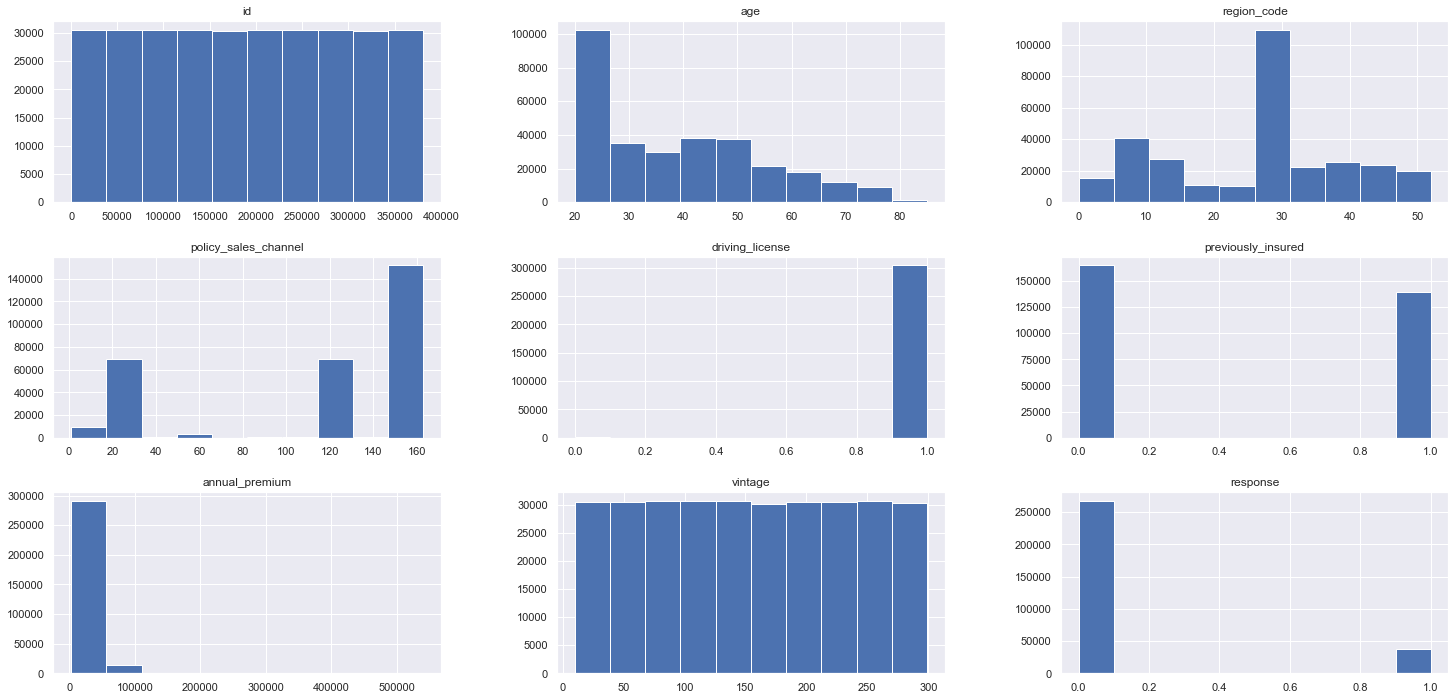

In [17]:
num_attributes.hist();

### 1.6.2 Categorical Attributes

In [18]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,304887,304887,304887
unique,2,3,2
top,Male,1-2 Year,Yes
freq,164828,160204,153804


### 1.6.3 Some Conclusions

Significant portion of customers (54,2%) don't have vehicle insurance

Most 95% of customer have license

All customers have less than one year of insurance and have a constant distribution

Most customers are under 50 years old, 25% are up to 25 years old

Most 95% of annual premmium cost until 55.292 and the range is 537535.0

Most customer are Male

Most customers vehicles age is less 2 years

Customers who have had the vehicle damaged in the past are evenly distributed to customers who have not had the vehicle damaged

Most 75% of customers don't have interest to buy a vehicle insurance

# 2.0 Feature Engineering

In [19]:
df02 = df01.copy()

## 2.1 Age Stage

We will create a variable with age range based on the following criteria:
- Child: people under the age of 10.
- Teenager: people aged between 10 and 20 years.
- Young: people aged between 20 and 30 years.
- Adult: people aged between 30 and 45 years.
- Midlife: people aged between 45 and 60 years.
- Senior: people aged between 60 and 70 years.
- Mature Adulthood: people aged between 70 and 80 years.
- Late Adulthood: people aged between 80 and 120 years.

> customers over 120 years old were disregarded

In [20]:
# Age Stage
df02['age_stage'] = df02['age'].apply(lambda row: age_stage(row))

## 2.2 vehicle age

The vehicle age has been converted to numerical values

- "< 1 Year": 0
- "1-2 Year": 1 
- "> 2 Years": 2

In [21]:
vehicle_age_mapping = {'< 1 Year':0,
                       '1-2 Year':1,
                       '> 2 Years':2}

df02['vehicle_age'] = df02['vehicle_age'].map(vehicle_age_mapping)

## 2.3 vehicle damage

The vehicle damage has been converted to numerical values
- "No":0
- "Yes":1

In [22]:
vehicle_damage_mapping = {'No':0,
                          'Yes':1}

df02['vehicle_damage'] = df02['vehicle_damage'].map(vehicle_damage_mapping)

## 2.4 vehicle demage versus license

| driving_license | vehicle_damage | vehicle_damage_license |
| :-------------: | :------------: | :--------------------: |
|        0        |       0        |           0            |
|        0        |       1        |          -1            |
|        1        |       0        |           1            |
|        1        |       1        |           4            |

In [23]:
df02['vehicle_damage_license'] = df02.apply(lambda row: -(row['vehicle_damage'] + row['driving_license'])**2\
                                            if row['driving_license'] == 0 else (row['vehicle_damage'] + row['driving_license'])**2, axis=1)

## 2.5 vehicle demage versus vehicle age

| vehicle_age | vehicle_damage | vehicle_damage_vehicle_age |
| :---------: | :------------: | :------------------------: |
|      0      |       0        |              0             |
|      0      |       1        |             -1             |
|      1      |       0        |              1             |
|      1      |       1        |             -4             |
|      2      |       0        |              4             |
|      2      |       1        |             -9             |

In [24]:
df02['vehicle_damage_vehicle_age'] = df02.apply(lambda row: -(row['vehicle_damage'] + row['vehicle_age'])**2\
                                                if row['vehicle_damage'] == 1 else (row['vehicle_damage'] + row['vehicle_age'])**2, axis=1)

## 2.6 ratio of age to average age by region

In [25]:
region_code_mean_age = pd.DataFrame(df02.groupby('region_code')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_region_code'})
df02 = pd.merge(df02, region_code_mean_age, how='left', on='region_code')

df02['age_mean_age_by_region_code'] = df02['age'] / df02['mean_age_by_region_code']
del region_code_mean_age

## 2.7 ratio of age to average age by policy sales channel

In [26]:
policy_sales_channel_mean_age = pd.DataFrame(df02.groupby('policy_sales_channel')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_policy_sales_channel'})
df02 = pd.merge(df02, policy_sales_channel_mean_age, how='left', on='policy_sales_channel')

df02['age_mean_age_by_policy_sales_channel'] = df02['age'] / df02['mean_age_by_policy_sales_channel']
del policy_sales_channel_mean_age

## 2.8 ratio of annual premmium to average annual premmium by redion

In [27]:
region_code_mean_annual_premium = pd.DataFrame(df02.groupby('region_code')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_region_code'})
df02 = pd.merge(df02, region_code_mean_annual_premium, how='left', on='region_code')

df02['annual_premium_mean_annual_premium_by_region_code'] = df02['annual_premium'] / df02['mean_annual_premium_by_region_code']
del region_code_mean_annual_premium

## 2.9 ratio of annual premmium to average annual premmium by policy sales channel

In [28]:
policy_sales_channel_mean_annual_premium = pd.DataFrame(df02.groupby('policy_sales_channel')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_policy_sales_channel'})
df02 = pd.merge(df02, policy_sales_channel_mean_annual_premium, how='left', on='policy_sales_channel')

df02['annual_premium_mean_annual_premium_by_policy_sales_channel'] = df02['annual_premium'] / df02['mean_annual_premium_by_policy_sales_channel']
del policy_sales_channel_mean_annual_premium

## 2.10 ratio of age (converted  for days) to the vintage

In [29]:
df02['age_vintage'] = (df02['age']*365) / df02['vintage']

## 2.11 Feaures to organize

In [30]:
# df02['gender'] = df02['gender'].apply(lambda row: 0 if row == 'Male' else 1)



# #customer_term_year
# df02['customer_term_year'] = df02['vintage']/365

# #insured_gender
# df02['insured_gender'] = (100 + 10*df02['previously_insured'] + df02['gender'])/100

# #license_insured
# df02['license_insured'] = (100 + 10*df02['driving_license'] + df02['previously_insured'])/100

# # # oportunity_by_policy_sales_channel (previously_insured)
# oportunity_by_policy_sales_channel = pd.DataFrame(df02.groupby('policy_sales_channel')['previously_insured'].mean()).reset_index().rename(columns={'previously_insured': 'oportunity_by_policy_sales_channel'})
# oportunity_by_policy_sales_channel['oportunity_by_policy_sales_channel'] = 1 - oportunity_by_policy_sales_channel['oportunity_by_policy_sales_channel']
# df02 = pd.merge(df02, oportunity_by_policy_sales_channel, how='left', on='policy_sales_channel')
# df02['oportunity_by_policy_sales_channel'] = df02.apply(lambda row: 0.0 if row['previously_insured'] == 1 else row['oportunity_by_policy_sales_channel'], axis=1)
# del oportunity_by_policy_sales_channel


# # oportunity_by_policy_sales_channel (previously_insured)
# oportunity_by_region_code = pd.DataFrame(df02.groupby('region_code')['previously_insured'].mean()).reset_index().rename(columns={'previously_insured': 'oportunity_by_region_code'})
# oportunity_by_region_code['oportunity_by_region_code'] = 1 - oportunity_by_region_code['oportunity_by_region_code']
# df02 = pd.merge(df02, oportunity_by_region_code, how='left', on='region_code')
# df02['oportunity_by_region_code'] = df02.apply(lambda row: 0.0 if row['previously_insured'] == 1 else row['oportunity_by_region_code'], axis=1)
# del oportunity_by_region_code


# age_stage_vehicle_damage_annual_premium = df02.groupby(['age_stage','vehicle_damage'])['annual_premium'].agg(['mean','std'])
# age_stage_vehicle_damage_annual_premium.columns = [x +'_age_damage_premium' for x in age_stage_vehicle_damage_annual_premium.columns.ravel()]
# df02 = pd.merge(df02, age_stage_vehicle_damage_annual_premium, on=['age_stage','vehicle_damage'], how='left')

# 3.0 Data Filtering

In [31]:
df03 = df02.copy()

## 3.1 Filtering Rows

## 3.2 Filtering Columns

In [32]:
cols_drop = ['id', # original data
             'mean_age_by_region_code', 'mean_age_by_policy_sales_channel', 'mean_annual_premium_by_region_code', 'mean_annual_premium_by_policy_sales_channel'] # auxiliary features
df03 = df03.drop(cols_drop, axis=1)

# 4.0 Exploratory Data Analysis (EDA)

In [33]:
df04 = df03.copy()

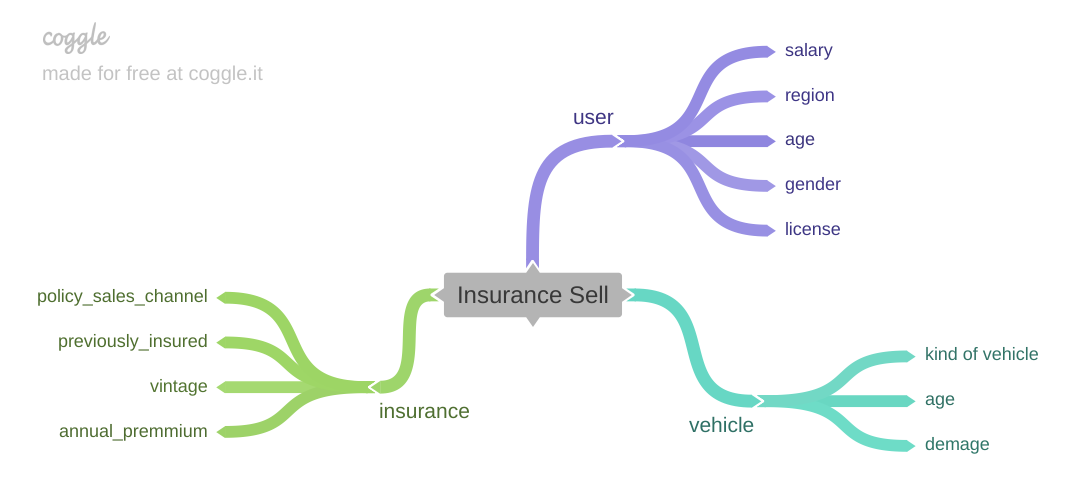

In [34]:
Image('../img/insurance_sell.png')

## 4.1 Univariate Analysis - Feature Bahaviour (Balanced Dataset)

In [35]:
profile = ProfileReport(df04, title="Insurance Cross Sell", html={'style': {'full_width':True}}, minimal=True)

profile.to_file(output_file='../reports/insurance_cross_sell.html')

## 4.2 Bivariate Analysis - Hypothesis Validation (Unbalanced dataset)

### 4.2.1 Hypothesis

> - **H01** - Customers over 30 years old purchase vehicle insurance more frequently
> - **H02** - Unlicensed customers do not purchase insurance
> - **H03** - Customers who already have vehicle insurance do not require the insurance offered
> - **H04** - Customers with vehicle that are less than 1 year old purchase insurance
> - **H05** - Longer customers who own vehicles that are more than 2 years old acquire insurance
> - **H06** - Male customers who own vehicles over 2 years of age do not acquire insurance
> - **H07** - Customers with the contract in force for longer do not acquire the insurance
> - **H08** - Elderly customers do not purchase insurance
> - **H09** - Female customers already have vehicle insurance
> - **H10** - Customers with new and damaged vehicles purchase the most insurance
> - **H11** - Customers who have a plan that covers more than the average in the region purchase the most insurance
> - **H12** - Older customers in the portfolio are from the region 28
> - **H13** - Young customers came through channel 152
> - **H14** - Of all age classes young people have the highest proportion of damaged cars

### 4.2.2 Final List of Hypothesis

> - **H01** - Customers over 30 years old purchase vehicle insurance
> - **H02** - Customers who already have vehicle insurance do not require the insurance offered
> - **H03** - Customers with vehicle that are less than 1 year old purchase insurance
> - **H04** - Longer customers who own vehicles that are more than 2 years old acquire insurance
> - **H05** - Male customers who own vehicles over 2 years of age do not acquire insurance
> - **H06** - Customers with the contract in force for longer do not acquire the insurance
> - **H07** - Customers with new and damaged vehicles purchase the most insurance
> - **H08** - Customers who have a plan that covers more than the average in the region purchase insurance
> - **H09** - Older customers in the portfolio are from the region 28
> - **H10** - Young customers came through channel 152
> - **H11** - Of all age classes young people have the highest proportion of damaged cars

#### **H01** - Customers over 30 years old purchase vehicle insurance more frequently
---
> **Conclusion: TRUE**
>> - Customers over 30 years old purchase vehicle insurance more frequently

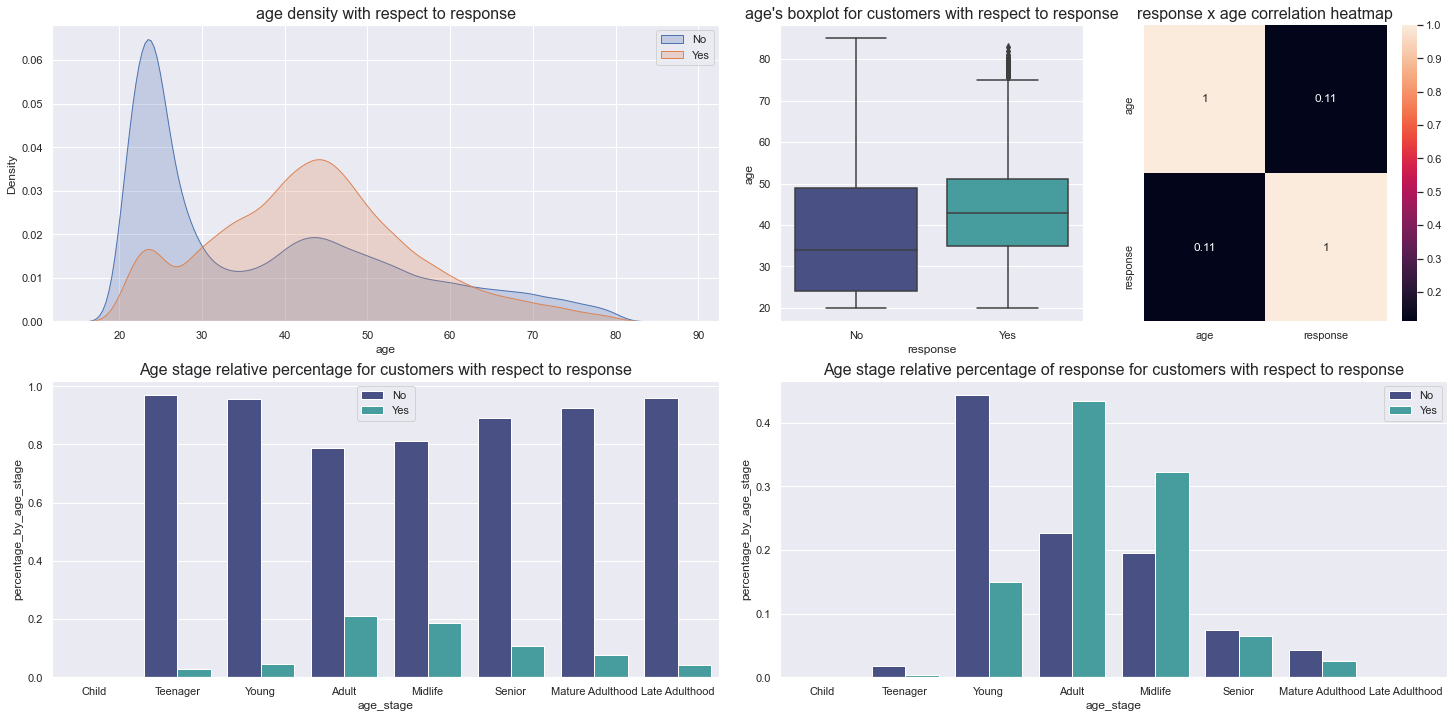

In [36]:
aux01 = df04[['age', 'age_stage', 'response']]


# Grid for ploting
grid = GridSpec(2, 4)

# response x age correlation heatmap
plt.subplot(grid[0,3:4])
sns.heatmap(aux01.corr(method='pearson'), annot=True).set_title("response x age correlation heatmap", fontsize=16);

# Change response to Yes/No
aux01['response'] = aux01['response'].apply(lambda row: 'Yes' if row == 1 else 'No')

# age density with respect to response
plt.subplot(grid[0,:2])
sns.kdeplot(aux01[aux01['response'] == 'No']['age'], label='No', shade=True, palette='mako');
sns.kdeplot(aux01[aux01['response'] == 'Yes']['age'], label='Yes', shade=True, palette='mako');
plt.title("age density with respect to response", fontsize=16);
plt.legend();

# age's boxplot for customers with respect to response
plt.subplot(grid[0,2:3])
sns.boxplot(x="response", y="age", data=aux01, palette='mako').set_title("age's boxplot for customers with respect to response", fontsize=16);

# Age stage relative percentage for customers with respect to response
aux02 = pd.DataFrame()
age_stage_unique = aux01['age_stage'].unique().tolist()
for stage in age_stage_unique:
    aux02_0 = aux01[aux01['age_stage'] == stage][['age_stage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})
    aux02 = pd.concat([aux02, aux02_0])

## sort the x axis
age_stage_order = ['Child', 'Teenager', 'Young', 'Adult','Midlife','Senior','Mature Adulthood','Late Adulthood']
aux02['age_stage'] = pd.Categorical(aux02['age_stage'], categories=age_stage_order, ordered =True)
aux02.sort_values('age_stage')

## plot
plt.subplot(grid[1,:2])
sns.barplot(x='age_stage', y='percentage_by_age_stage', hue='response', data=aux02, palette='mako');
plt.legend();
plt.title("Age stage relative percentage for customers with respect to response", fontsize=16);

# Age stage relative percentage of response for customers with respect to response
aux02_0 = aux01[aux01['response'] == 'No'][['age_stage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})
aux02_1 = aux01[aux01['response'] == 'Yes'][['age_stage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})

aux02 = pd.concat([aux02_0, aux02_1], axis=0)

## sort the x axis
aux02['age_stage'] = pd.Categorical(aux02['age_stage'], categories=age_stage_order, ordered =True)
aux02.sort_values('age_stage')

## plot
plt.subplot(grid[1,2:4])
sns.barplot(x='age_stage', y='percentage_by_age_stage', hue='response', data=aux02, palette='mako');
plt.legend();
plt.title("Age stage relative percentage of response for customers with respect to response", fontsize=16);

#### **H02** - Customers who already have vehicle insurance do not require the insurance offered
---
> **Conclusion: TRUE**
>> - Customers who already have vehicle insurance do not require the insurance offered

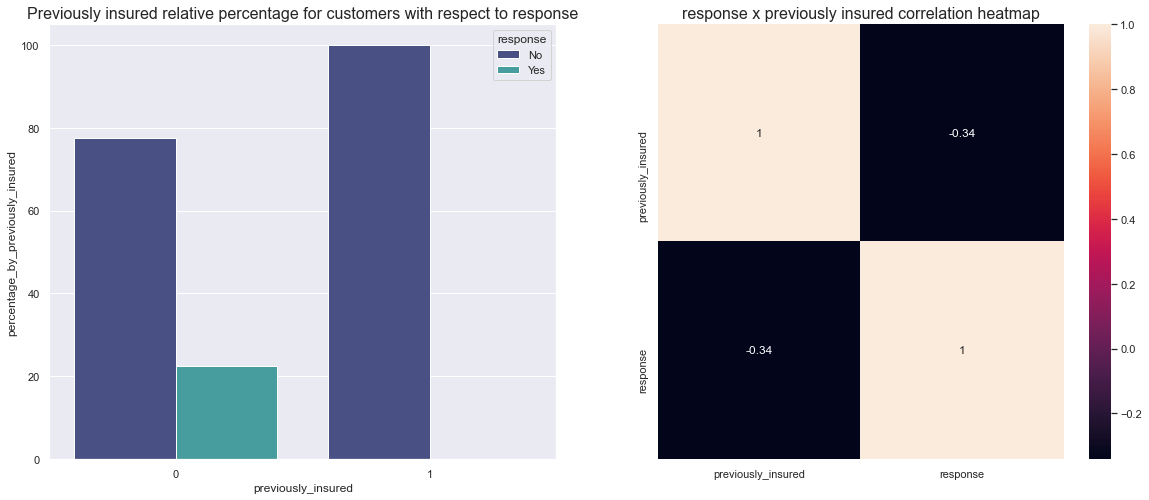

In [37]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
aux02 = df04[['previously_insured', 'response']]
# Previously insured relative percentage for customers with respect to response
aux02_0 = aux02[aux02['previously_insured'] == 1][['previously_insured', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_previously_insured'})
aux02_1 = aux02[aux02['previously_insured'] == 0][['previously_insured', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_previously_insured'})
aux03 = pd.concat([aux02_0, aux02_1], axis=0)

## Change response to Yes/No
aux03['response'] = aux03['response'].apply(lambda row: 'Yes' if row == 1 else 'No')
## transform to 100%
aux03['percentage_by_previously_insured'] = aux03['percentage_by_previously_insured'] * 100

## plot
sns.barplot(x='previously_insured', y='percentage_by_previously_insured', hue='response', data=aux03, palette='mako');
plt.title("Previously insured relative percentage for customers with respect to response", fontsize=16)

# response x previously insured correlation heatmap
plt.subplot(1,2,2)
sns.heatmap(aux02.corr(method='pearson'), annot=True).set_title("response x previously insured correlation heatmap", fontsize=16);

#### **H03** - Customers with vehicle that are less than 1 year old purchase insurance
---
> **Conclusion: FALSE**
>> - Customers with vehicle that are less than 1 year old do not purchase insurance

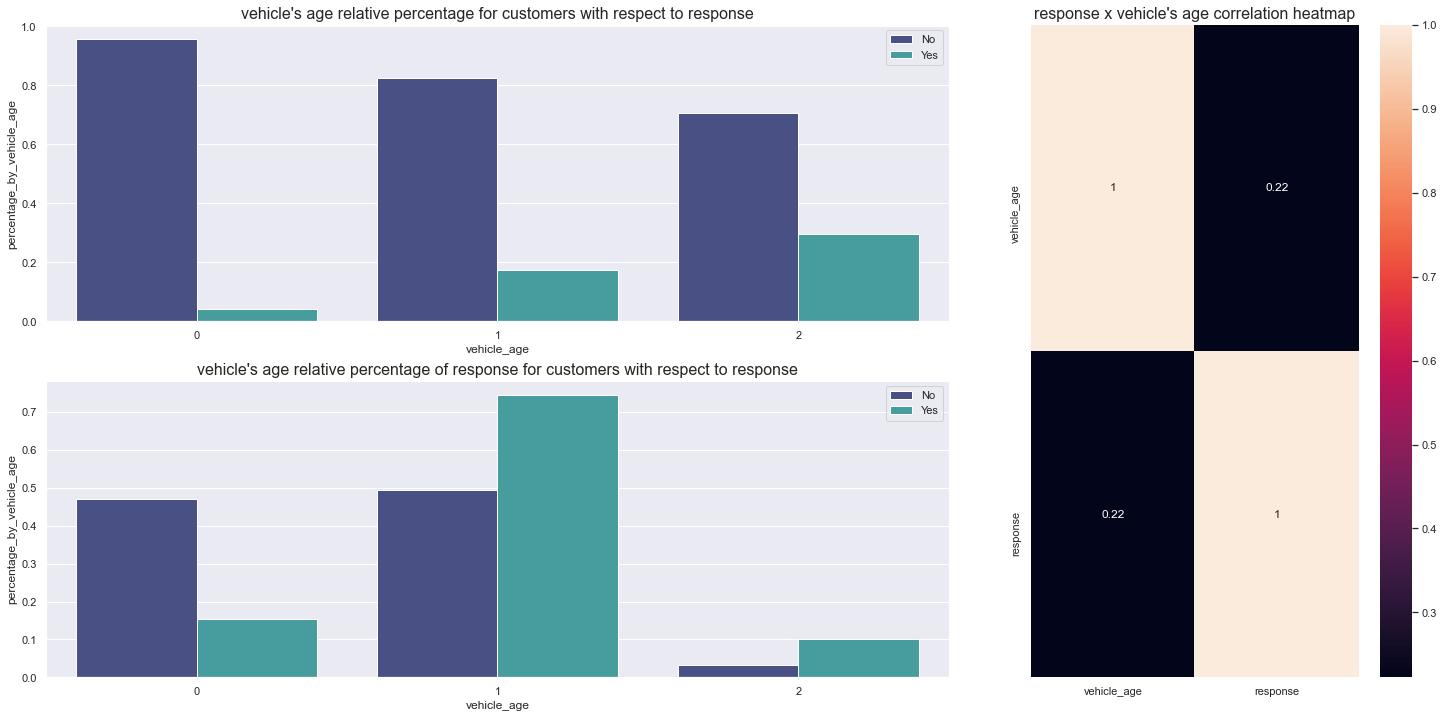

In [38]:
aux03 = df04[['vehicle_age', 'response']]

# Grid for ploting
plt.figure(figsize=(25, 12))
grid = GridSpec(2, 3)

# response x vehicle's age correlation heatmap
plt.subplot(grid[:,2])
sns.heatmap(aux03.corr(method='pearson'), annot=True).set_title("response x vehicle's age correlation heatmap", fontsize=16);

# Change response to Yes/No
aux03['response'] = aux03['response'].apply(lambda row: 'Yes' if row == 1 else 'No')

# vehicle's age relative percentage for customers with respect to response
aux04 = pd.DataFrame()
vehicle_age_unique = aux03['vehicle_age'].unique().tolist()
for age in vehicle_age_unique:
    aux04_0 = aux03[aux03['vehicle_age'] == age][['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
    aux04 = pd.concat([aux04, aux04_0])

## plot
plt.subplot(grid[0,:2])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux04, palette='mako');
plt.legend();
plt.title("vehicle's age relative percentage for customers with respect to response", fontsize=16);



# Age stage relative percentage of response for customers with respect to response
aux03_0 = aux03[aux03['response'] == 'No'][['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
aux03_1 = aux03[aux03['response'] == 'Yes'][['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
aux03 = pd.concat([aux03_0, aux03_1], axis=0)

## plot
plt.subplot(grid[1,:2])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux03, palette='mako');
plt.legend();
plt.title("vehicle's age relative percentage of response for customers with respect to response", fontsize=16);

#### **H04** -  Longer customers who own vehicles that are more than 2 years old acquire insurance
---
> **Conclusion: FALSE**
>> - Longer customers who own vehicles that are more than 2 years old acquire insurance in the same frequency of the other customers

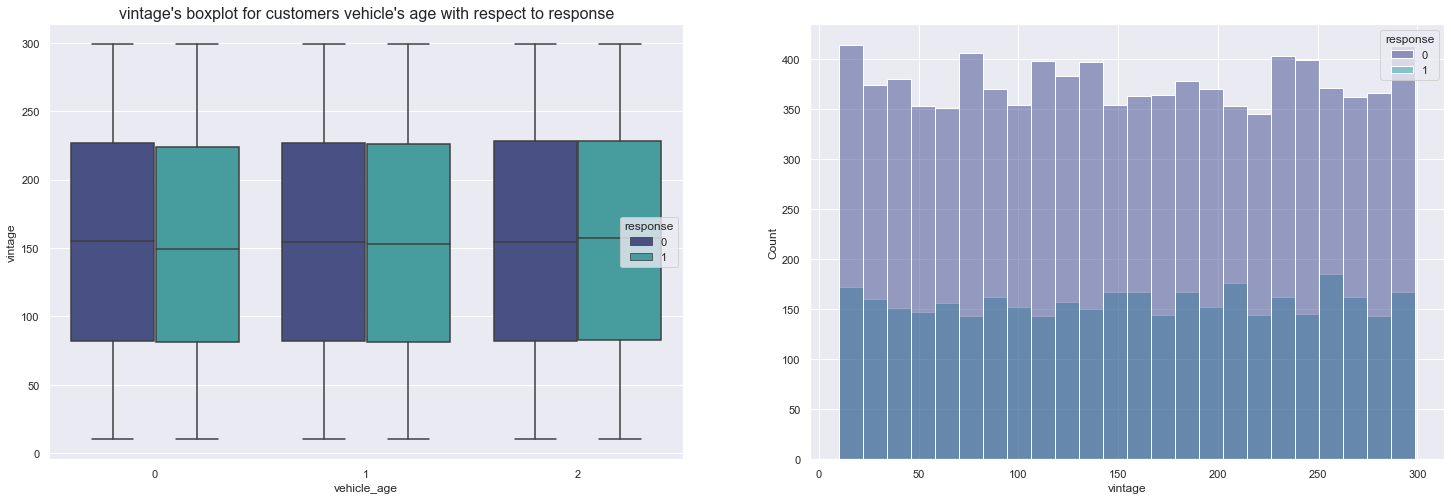

In [39]:
aux04 = df04[['vintage','vehicle_age', 'response']]

plt.figure(figsize=(25,8))
# age's boxplot for customers with respect to response
plt.subplot(1,2,1)
sns.boxplot(x="vehicle_age", y="vintage", hue="response", data=aux04, palette='mako').set_title("vintage's boxplot for customers vehicle's age with respect to response", fontsize=16);

plt.subplot(1,2,2)
sns.histplot(x='vintage', data=aux04[aux04['vehicle_age'] == 2], hue='response', palette='mako');

#### **H05** - Male customers who own vehicles over 2 years of age do not acquire insurance
---
> **Conclusion: False**
>> - Male customers who own vehicles over 2 years of age acquire insurance

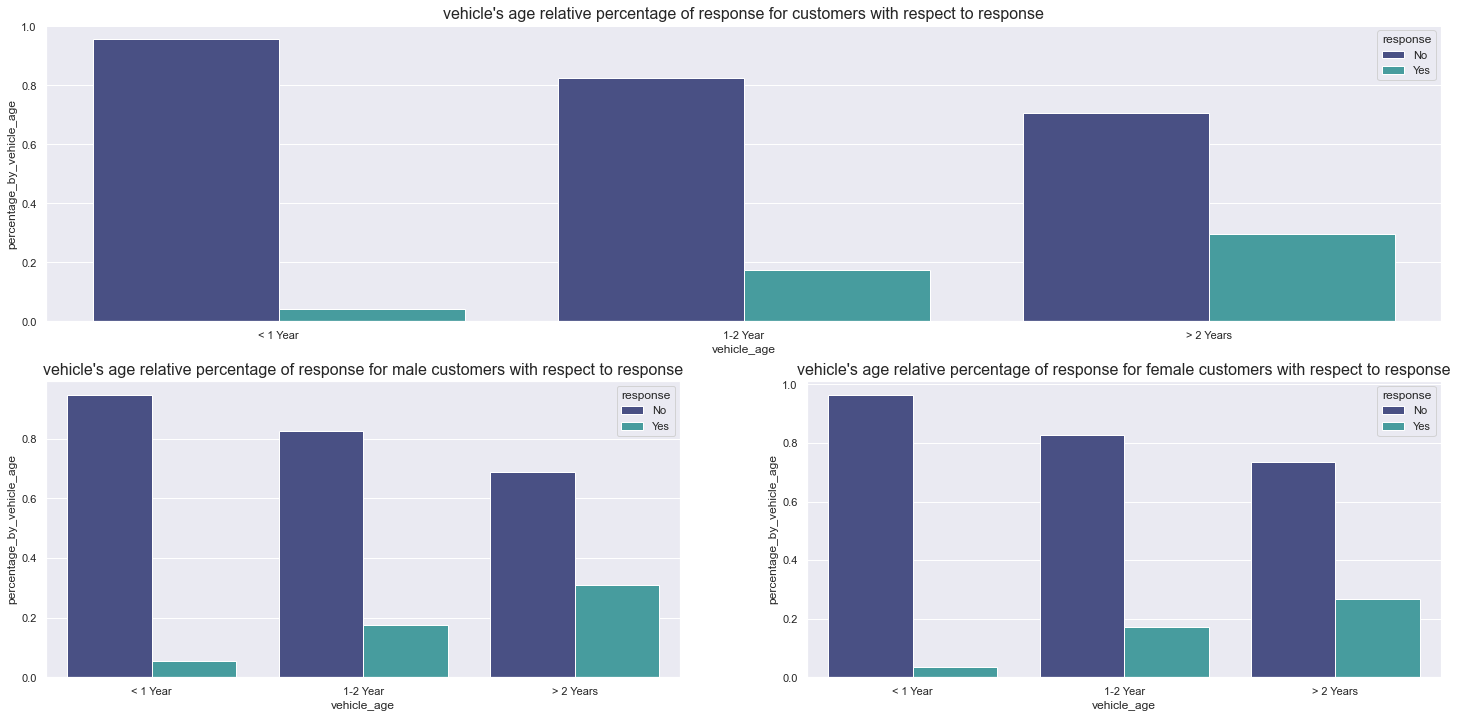

In [40]:
aux05 = df04[['gender','vehicle_age', 'response']]

aux05_0 = pd.DataFrame()
aux05_2 = pd.DataFrame()
aux05_4 = pd.DataFrame()
vehicle_age_unique = aux05['vehicle_age'].unique().tolist()
for age in vehicle_age_unique:
    # All Genders
    aux05_1 = aux05[aux05['vehicle_age'] == age][['vehicle_age', 'response']]\
                                                    .value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
    # Male
    aux05_3 = aux05[(aux05['gender'] == 'Male') & (aux05['vehicle_age'] == age)][['vehicle_age', 'response']]\
                                                    .value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
    # Female
    aux05_5 = aux05[(aux05['gender'] == 'Female') & (aux05['vehicle_age'] == age)][['vehicle_age', 'response']]\
                                                    .value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
    
    # All genders
    aux05_0 = pd.concat([aux05_0, aux05_1])
    # Male
    aux05_2 = pd.concat([aux05_2, aux05_3])
    # Female
    aux05_4 = pd.concat([aux05_4, aux05_5])


# vehicle age
vehicle_age_mapping = {0:'< 1 Year',
                       1:'1-2 Year',
                       2:'> 2 Years'}

aux05_0['vehicle_age'] = aux05_0['vehicle_age'].map(vehicle_age_mapping)
aux05_2['vehicle_age'] = aux05_2['vehicle_age'].map(vehicle_age_mapping)
aux05_4['vehicle_age'] = aux05_4['vehicle_age'].map(vehicle_age_mapping)

# Change response to Yes/No
aux05_0['response'] = aux05_0['response'].apply(lambda row: 'Yes' if row == 1 else 'No')
aux05_2['response'] = aux05_2['response'].apply(lambda row: 'Yes' if row == 1 else 'No')
aux05_4['response'] = aux05_4['response'].apply(lambda row: 'Yes' if row == 1 else 'No')

grid = GridSpec(2, 2)

plt.subplot(grid[0,:])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux05_0, palette='mako');
plt.title("vehicle's age relative percentage of response for customers with respect to response", fontsize=16);

plt.subplot(grid[1,0])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux05_2, palette='mako');
plt.title("vehicle's age relative percentage of response for male customers with respect to response", fontsize=16);

plt.subplot(grid[1,1])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux05_4, palette='mako');
plt.title("vehicle's age relative percentage of response for female customers with respect to response", fontsize=16);

#### **H06** - Customers with the contract in force for longer do not acquire the insurance
---
> **Conclusion: FALSE**
>> - Customers with a longer-term contract purchase insurance in the same proportion as customers with a shorter-term contract

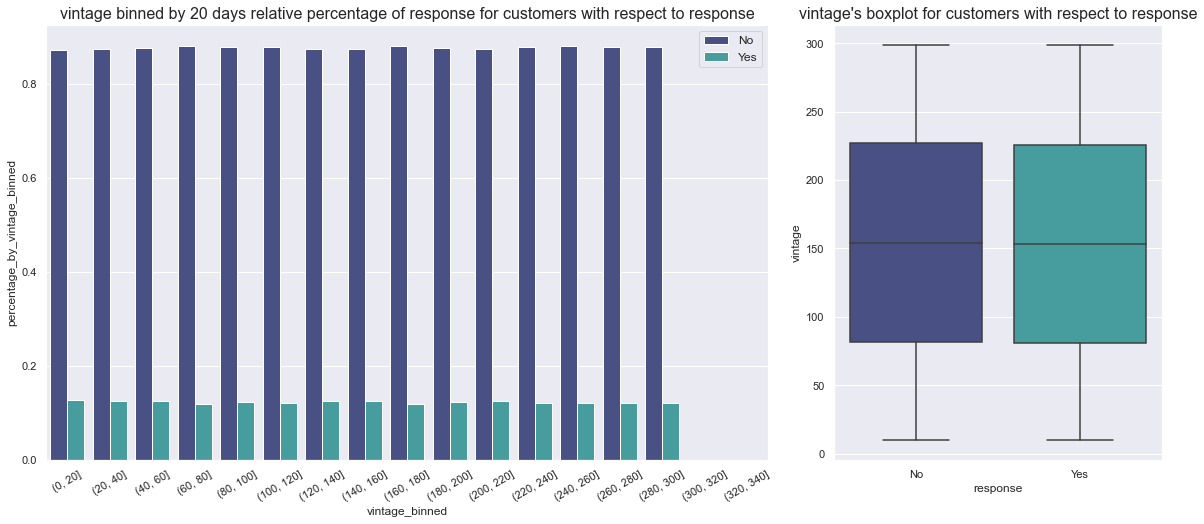

In [41]:
aux06 = df04[['vintage', 'response']]

# bins
bins = list(np.arange(0, 360, 20))

aux06['vintage_binned'] = pd.cut(aux06['vintage'], bins=bins)

# Change response to Yes/No
aux06['response'] = aux06['response'].apply(lambda row: 'Yes' if row == 1 else 'No')

plt.figure(figsize=(20,8))
grid = GridSpec(1, 3)

vintage_binned_unique = aux06['vintage_binned'].unique().tolist()

aux06_0 = pd.DataFrame()
for vintage_bin in vintage_binned_unique:
    aux06_1 = aux06[aux06['vintage_binned'] == vintage_bin][['vintage_binned', 'response']].\
                                                value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vintage_binned'})
    aux06_0 = pd.concat([aux06_0, aux06_1])

plt.subplot(grid[0,:2])    
sns.barplot(x='vintage_binned', y='percentage_by_vintage_binned', hue='response', data=aux06_0, palette='mako');
plt.title("vintage binned by 20 days relative percentage of response for customers with respect to response", fontsize=16);
plt.legend(loc='upper right', fontsize='medium')
plt.xticks(rotation=30);

plt.subplot(grid[0,2:])
sns.boxplot(x='response', y='vintage', data=aux06, palette='mako').set_title("vintage's boxplot for customers with respect to response", fontsize=16);

#### **H07** - Customers with new and damaged vehicles purchase the most insurance
---
> **Conclusion: FALSE**
>> - Customers with new and damaged vehicles purchase the less insurance

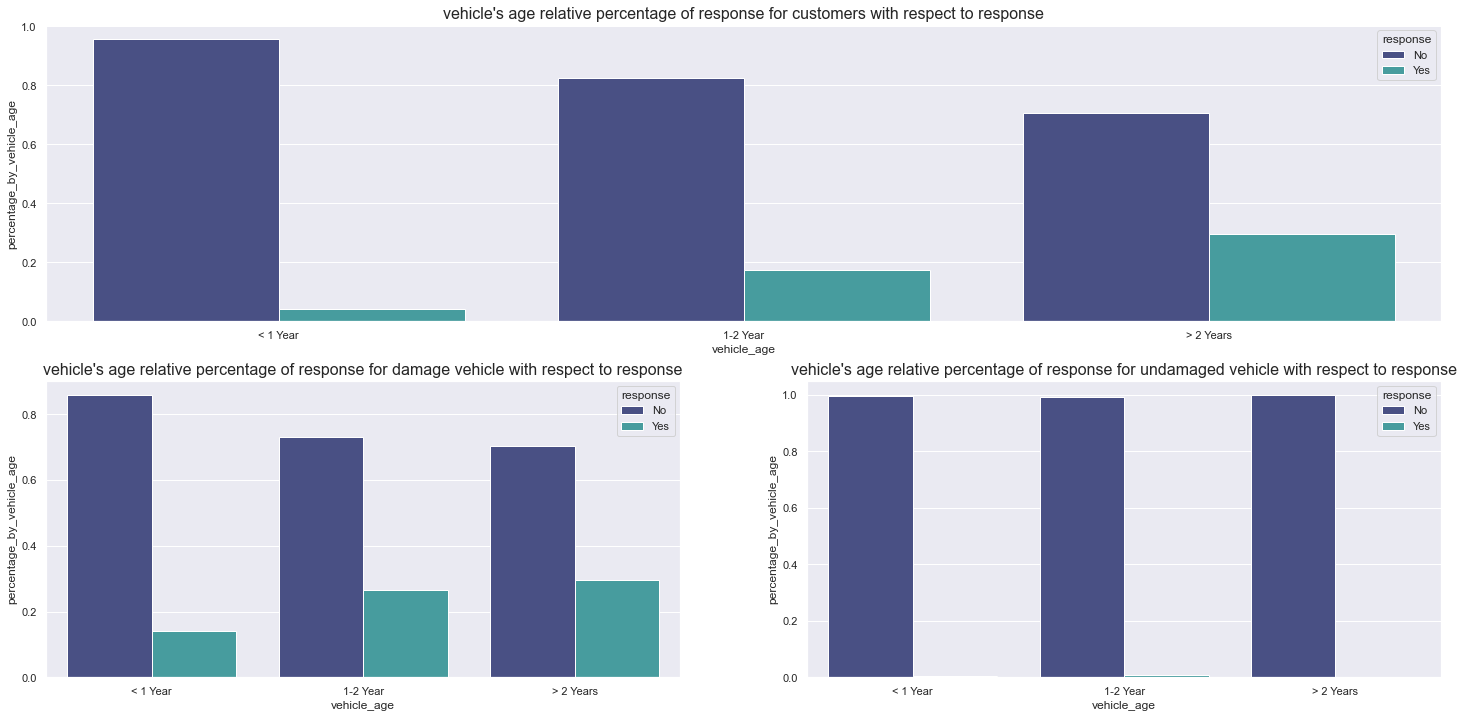

In [42]:
aux07 = df04[['vehicle_age', 'vehicle_damage', 'response']]

vehicle_age_unique = aux07['vehicle_age'].unique().tolist()


aux07_0 = pd.DataFrame()
aux07_2 = pd.DataFrame()
aux07_4 = pd.DataFrame()
for age in vehicle_age_unique:
    # damaged vehicle not applied
    aux07_1 = aux07[aux07['vehicle_age'] == age][['vehicle_age', 'response']]\
                                                    .value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})    
    # damage vehicle True
    aux07_3 = aux07[(aux07['vehicle_damage'] == 1) & (aux07['vehicle_age'] == age)][['vehicle_age', 'response']]\
                                                    .value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
    # damage vehicle False
    aux07_5 = aux07[(aux07['vehicle_damage'] == 0) & (aux07['vehicle_age'] == age)][['vehicle_age', 'response']]\
                                                    .value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
    
    # damaged vehicle not applied
    aux07_0 = pd.concat([aux07_0, aux07_1])
    # damage vehicle True
    aux07_2 = pd.concat([aux07_2, aux07_3])
    # damage vehicle False
    aux07_4 = pd.concat([aux07_4, aux07_5])


# vehicle age
vehicle_age_mapping = {0:'< 1 Year',
                       1:'1-2 Year',
                       2:'> 2 Years'}

aux07_0['vehicle_age'] = aux07_0['vehicle_age'].map(vehicle_age_mapping)
aux07_2['vehicle_age'] = aux07_2['vehicle_age'].map(vehicle_age_mapping)
aux07_4['vehicle_age'] = aux07_4['vehicle_age'].map(vehicle_age_mapping)

# Change response to Yes/No
aux07_0['response'] = aux07_0['response'].apply(lambda row: 'Yes' if row == 1 else 'No')
aux07_2['response'] = aux07_2['response'].apply(lambda row: 'Yes' if row == 1 else 'No')
aux07_4['response'] = aux07_4['response'].apply(lambda row: 'Yes' if row == 1 else 'No')


grid = GridSpec(2, 2)

plt.subplot(grid[0,:])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux07_0, palette='mako');
plt.title("vehicle's age relative percentage of response for customers with respect to response", fontsize=16);

plt.subplot(grid[1,0])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux07_2, palette='mako');
plt.title("vehicle's age relative percentage of response for damage vehicle with respect to response", fontsize=16);

plt.subplot(grid[1,1])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux07_4, palette='mako');
plt.title("vehicle's age relative percentage of response for undamaged vehicle with respect to response", fontsize=16);

#### **H08** - Customers who have a plan that covers more than the average in the region purchase the most insurance
---
> **Conclusion: FALSE**
>> - Customers who have a plan that covers more than the average in the region purchase the same proportion insurance

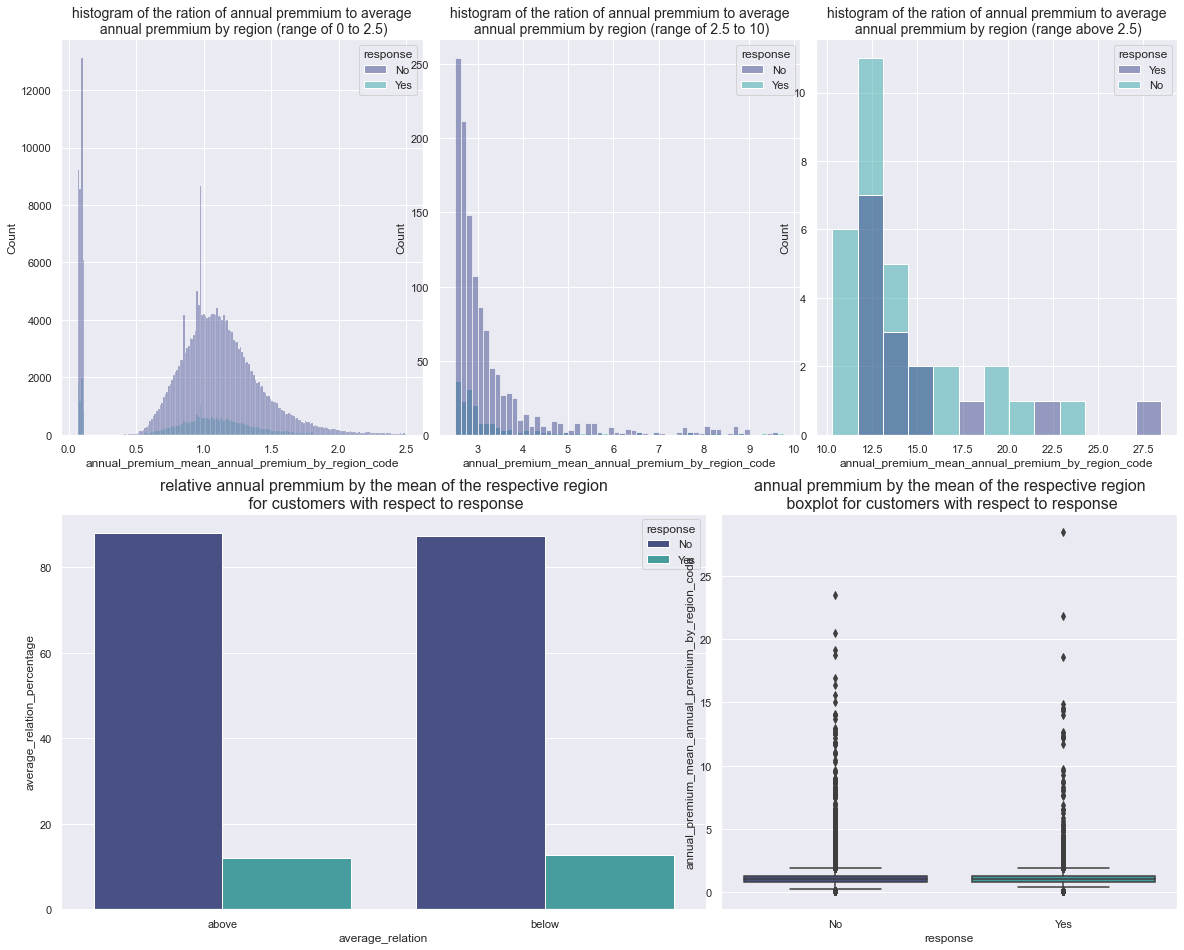

In [43]:
aux08 = df04[['annual_premium_mean_annual_premium_by_region_code', 'response']]

# Change response to Yes/No
aux08['response'] = aux08['response'].apply(lambda row: 'Yes' if row == 1 else 'No')

cort = 2.5
cort_2 = 10

aux08_0 = aux08[aux08['annual_premium_mean_annual_premium_by_region_code'] < cort]
aux08_1 = aux08[(aux08['annual_premium_mean_annual_premium_by_region_code'] >= cort) & (aux08['annual_premium_mean_annual_premium_by_region_code'] < cort_2)]
aux08_2 = aux08[aux08['annual_premium_mean_annual_premium_by_region_code'] >= cort_2]

plt.figure(figsize=(20, 16))
grid = GridSpec(2, 12)

plt.subplot(grid[0, :4])
sns.histplot(x='annual_premium_mean_annual_premium_by_region_code', data=aux08_0, hue='response', palette='mako');
plt.title("histogram of the ration of annual premmium to average\n annual premmium by region (range of 0 to {})".format(cort), fontsize=14);

plt.subplot(grid[0, 4:8])
sns.histplot(x='annual_premium_mean_annual_premium_by_region_code', data=aux08_1, hue='response', palette='mako');
plt.title("histogram of the ration of annual premmium to average\n annual premmium by region (range of {} to {})".format(cort,cort_2), fontsize=14);

plt.subplot(grid[0, 8:])
sns.histplot(x='annual_premium_mean_annual_premium_by_region_code', data=aux08_2, hue='response', palette='mako');
plt.title("histogram of the ration of annual premmium to average\n annual premmium by region (range above {})".format(cort), fontsize=14);


aux08_3 = aux08[aux08['annual_premium_mean_annual_premium_by_region_code'] > 1].groupby('response').size().reset_index().rename(columns={0:"total"})
aux08_3['average_relation_percentage'] = aux08_3['total'] / aux08_3['total'].sum() * 100
aux08_3['average_relation'] = 'above'

aux08_4 = aux08[aux08['annual_premium_mean_annual_premium_by_region_code'] <= 1].groupby('response').size().reset_index().rename(columns={0:"total"})
aux08_4['average_relation_percentage'] = aux08_4['total'] / aux08_4['total'].sum() * 100
aux08_4['average_relation'] = 'below'

aux08_4 = pd.concat([aux08_3, aux08_4], axis=0)

plt.subplot(grid[1, :7])
sns.barplot(x='average_relation', y='average_relation_percentage', hue='response', data=aux08_4, palette='mako');
plt.title("relative annual premmium by the mean of the respective region\n for customers with respect to response", fontsize=16);

plt.subplot(grid[1, 7:])
sns.boxplot(x='response', y='annual_premium_mean_annual_premium_by_region_code', data=aux08, palette='mako');
plt.title("annual premmium by the mean of the respective region\n boxplot for customers with respect to response", fontsize=16);

#### **H09** - Older customers in the portfolio are from the region 28
---
> **Conclusion: FALSE**
>> - the vintage ratio is equally distributed

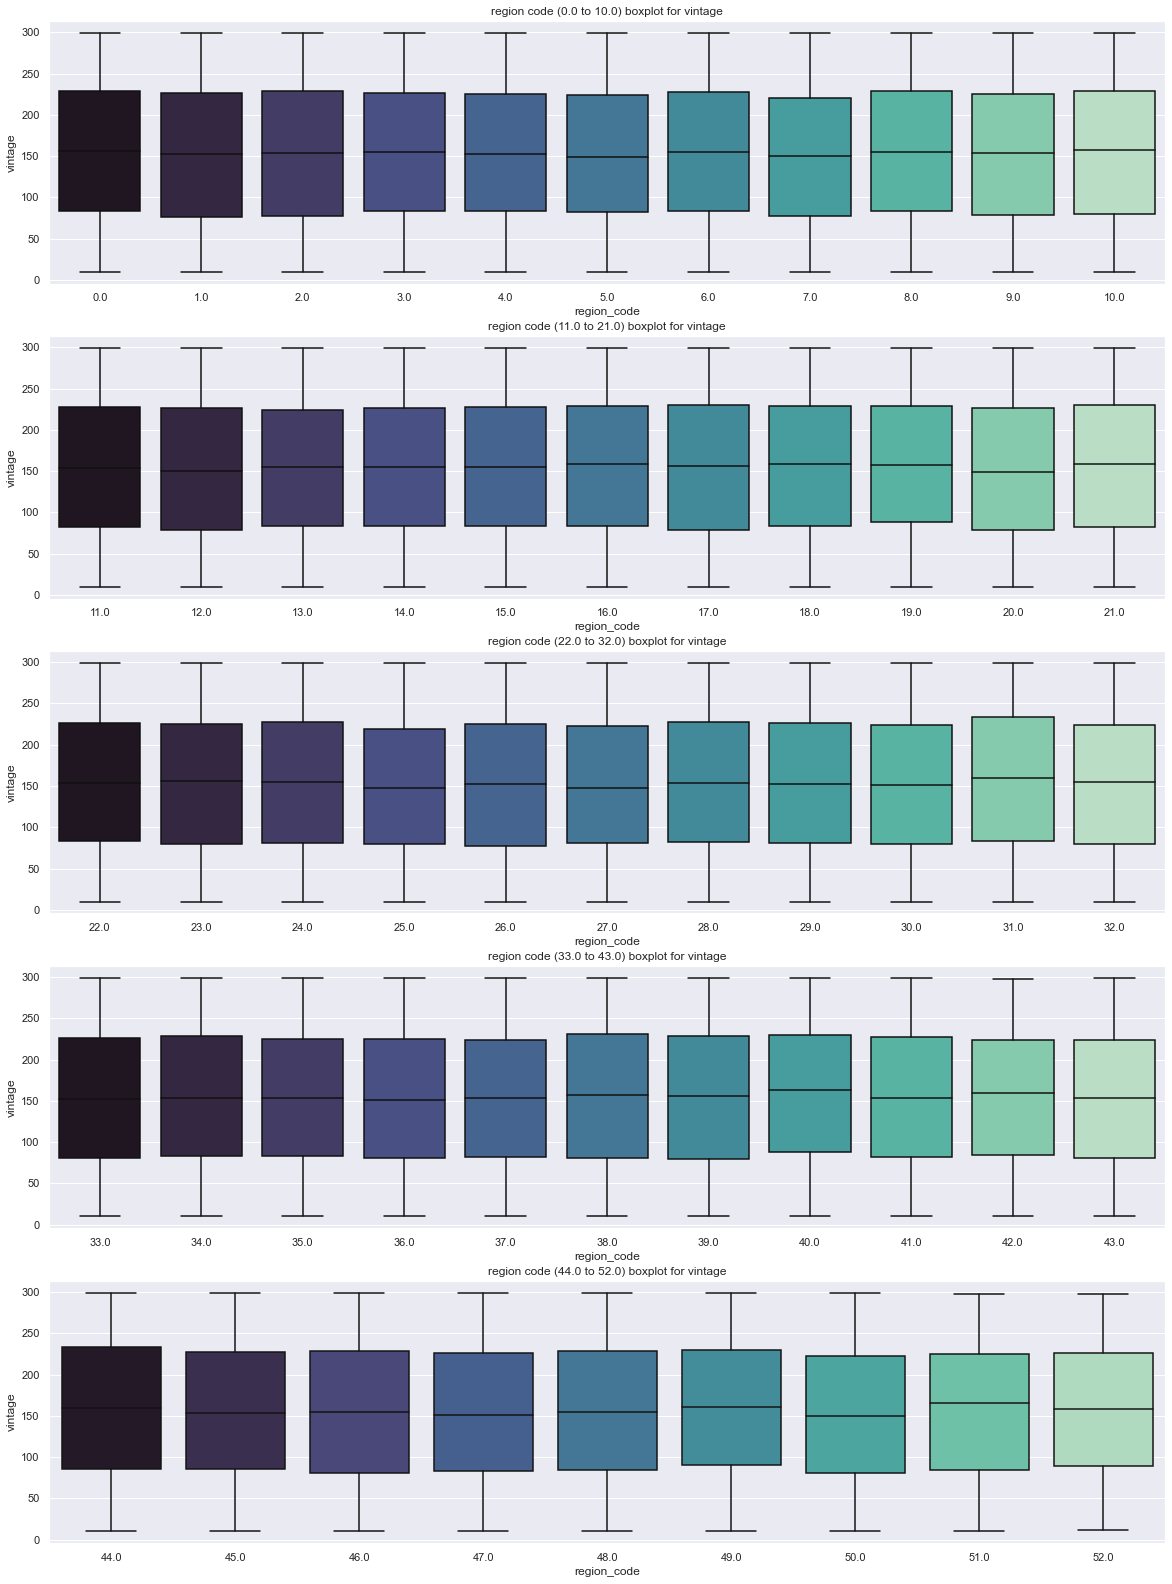

In [44]:
aux09 = df04[['vintage', 'region_code']].sort_values('region_code')

num_of_plots = 5
range_plots = round(len(aux09['region_code'].unique().tolist())/num_of_plots)
list_region_code = aux09['region_code'].unique().tolist()

plt.figure(figsize=(20, 28));

for i in range(num_of_plots):
    if i != num_of_plots - 1:
        aux09_1 = aux09[aux09['region_code'].isin(list_region_code[i * range_plots:(i+1) * range_plots])]
        plt.subplot(num_of_plots,1, i+1)
        sns.boxplot(x='region_code', y='vintage', data=aux09_1, palette='mako');
        plt.title("region code ({} to {}) boxplot for vintage".format(list_region_code[i * range_plots], list_region_code[(i+1) * range_plots -1]));

    else:
        aux09_1 = aux09[aux09['region_code'].isin(list_region_code[i * range_plots:])]
        plt.subplot(num_of_plots,1, i+1)
        sns.boxplot(x='region_code', y='vintage', data=aux09_1, palette='mako');
        plt.title("region code ({} to {}) boxplot for vintage".format(list_region_code[i * range_plots], list_region_code[-1]));

#### **H10** - Young customers came through channel 152
---
> **Conclusion: FALSE**
>> - Young customers came through channel 159

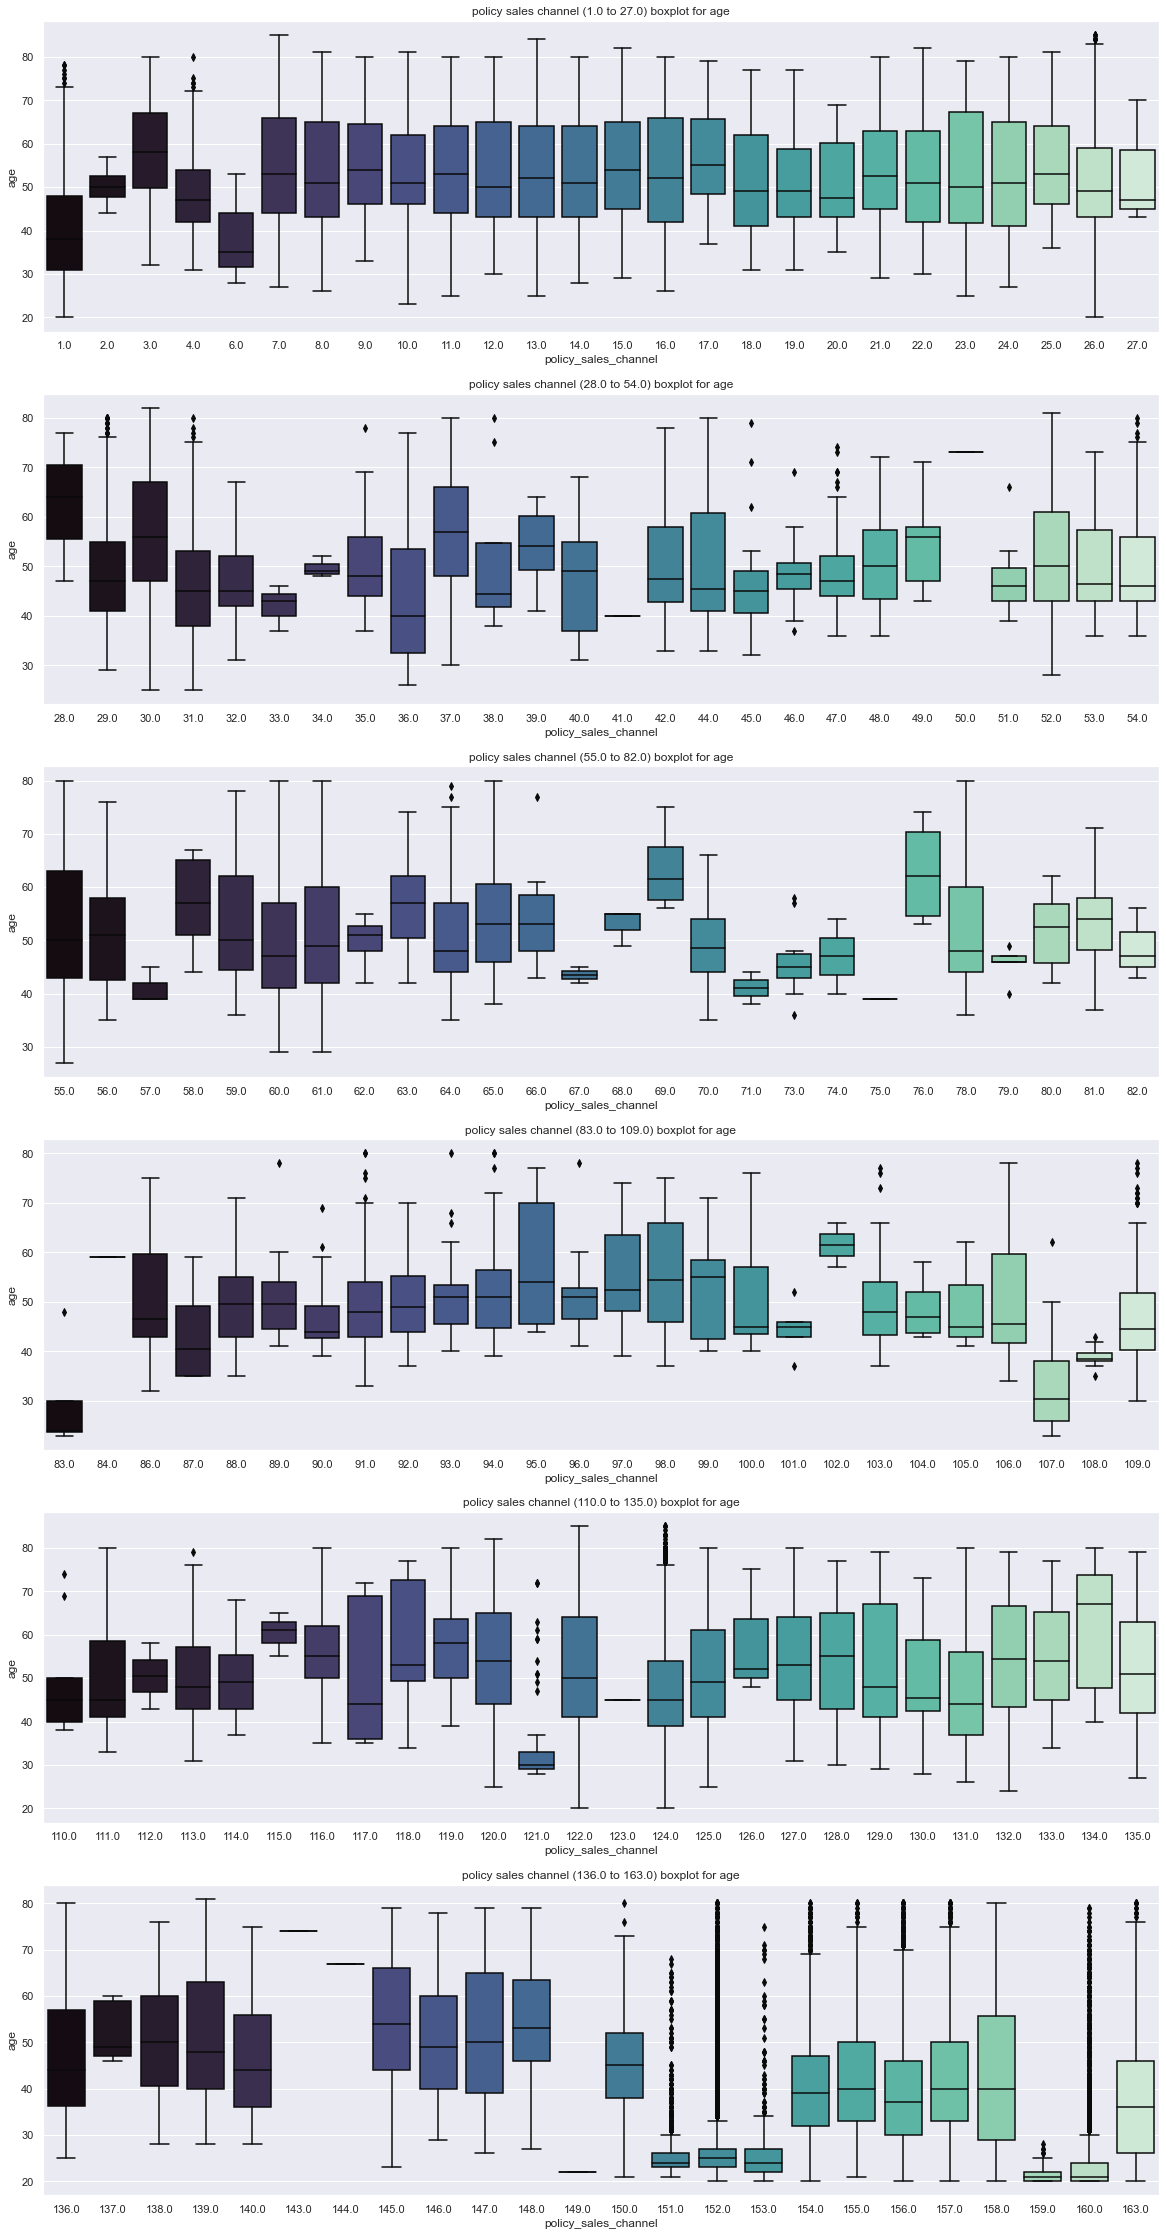

In [45]:
aux10 = df04[['age', 'policy_sales_channel']].sort_values('policy_sales_channel')

num_of_plots = 6
range_plots = round(len(aux10['policy_sales_channel'].unique().tolist())/num_of_plots)
list_region_code = aux10['policy_sales_channel'].unique().tolist()

plt.figure(figsize=(20, 40));

for i in range(num_of_plots):
    if i != num_of_plots - 1:
        aux10_1 = aux10[aux10['policy_sales_channel'].isin(list_region_code[i * range_plots:(i+1) * range_plots])]
        plt.subplot(num_of_plots,1, i+1)
        sns.boxplot(x='policy_sales_channel', y='age', data=aux10_1, palette='mako');
        plt.title("policy sales channel ({} to {}) boxplot for age".format(list_region_code[i * range_plots], list_region_code[(i+1) * range_plots -1]));

    else:
        aux10_1 = aux10[aux10['policy_sales_channel'].isin(list_region_code[i * range_plots:])]
        plt.subplot(num_of_plots,1, i+1)
        sns.boxplot(x='policy_sales_channel', y='age', data=aux10_1, palette='mako');
        plt.title("policy sales channel ({} to {}) boxplot for age".format(list_region_code[i * range_plots], list_region_code[-1]));


#### **H11** - Of all age classes young people have the highest proportion of damaged cars
---
> **Conclusion: FALSE**
>> - Of all age classes Midlife people have the highest proportion of damaged cars

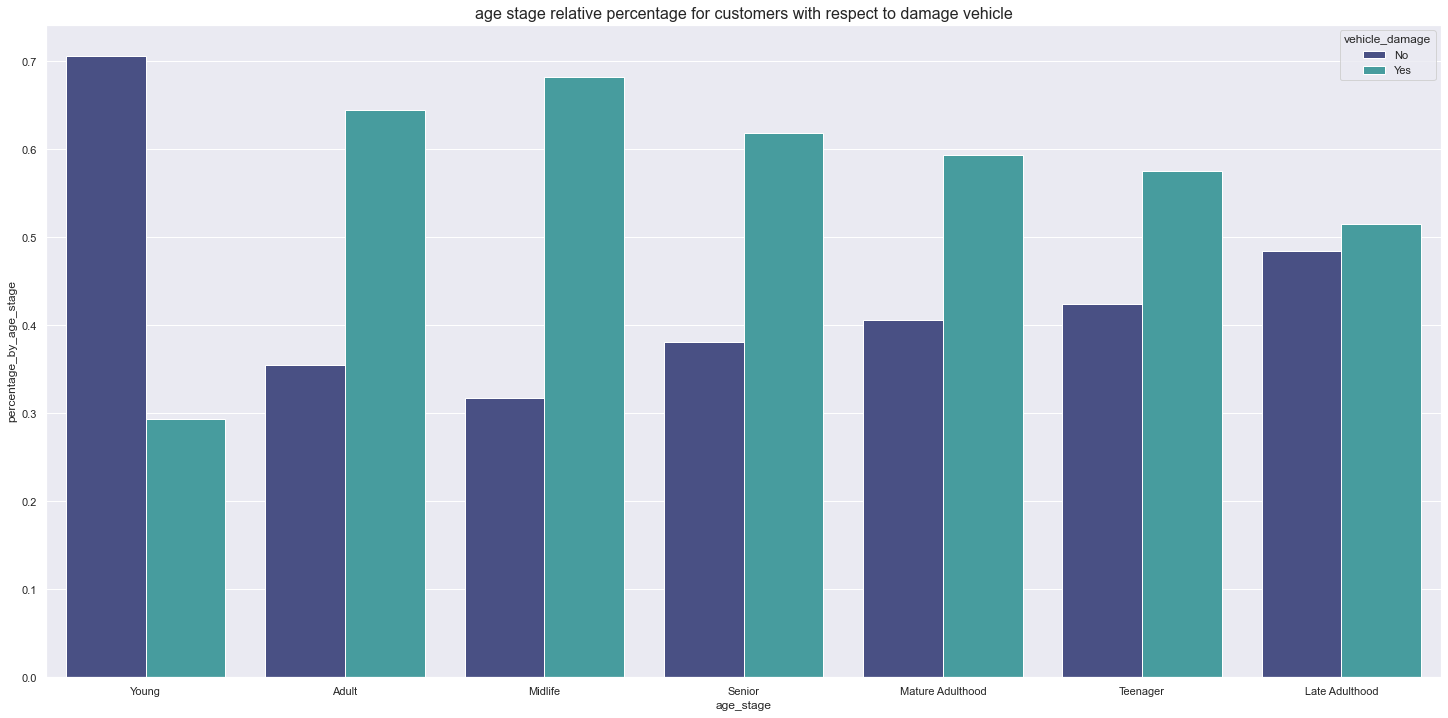

In [46]:
aux11 = df04[['age_stage', 'vehicle_damage']]

# Change response to Yes/No
aux11['vehicle_damage'] = aux11['vehicle_damage'].apply(lambda row: 'Yes' if row == 1 else 'No')

age_stage_unique = aux11['age_stage'].unique().tolist()

aux11_0 = pd.DataFrame()

for age in age_stage_unique:
    # 
    aux11_1 = aux11[aux11['age_stage'] == age][['age_stage', 'vehicle_damage']]\
                                                    .value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})    
    
    # 
    aux11_0 = pd.concat([aux11_0, aux11_1])
    
sns.barplot(x='age_stage', y='percentage_by_age_stage', hue='vehicle_damage', data=aux11_0, palette='mako');
plt.title("age stage relative percentage for customers with respect to damage vehicle", fontsize=16);

## 4.3 Multivariable analysis (Balanced Dataset)

In [47]:
cat_cols = ['region_code', 'policy_sales_channel', 'driving_license', 'vehicle_damage']

num_attributes = df04.select_dtypes(include=['int64', 'float64'])
num_attributes = num_attributes.drop(cat_cols, axis=1)

cat_attributes = df04.select_dtypes(exclude=['int64', 'float64'])
cat_attributes_list = cat_attributes.columns.tolist()
cat_attributes_list.extend(cat_cols)
cat_attributes = df04[cat_attributes_list]

### 4.3.1 Numerical

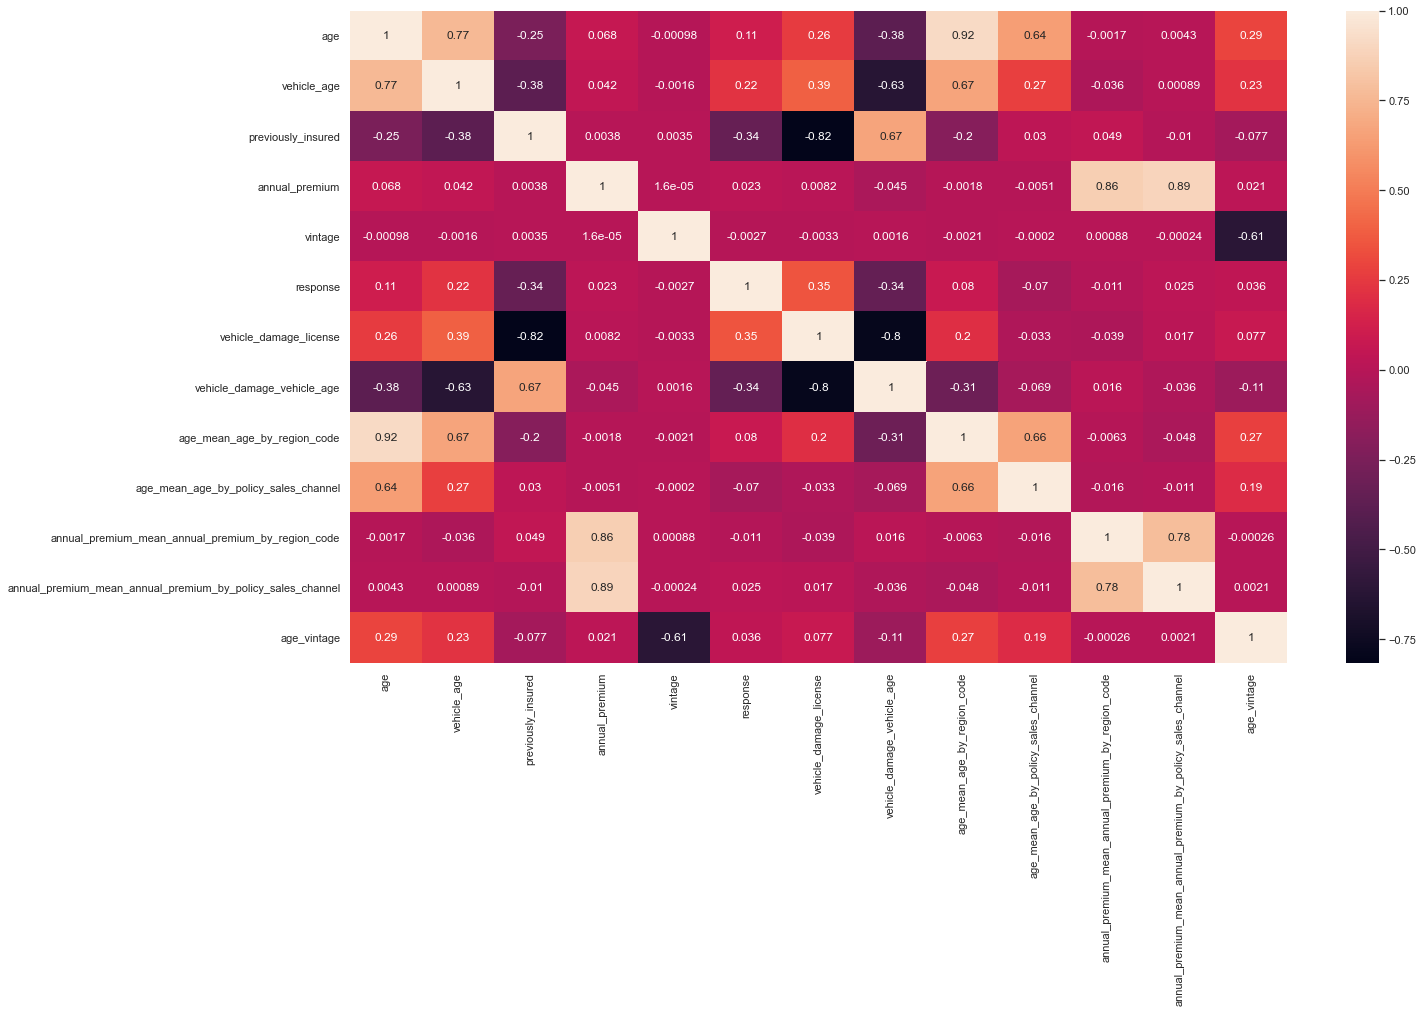

In [48]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(21,12))
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical

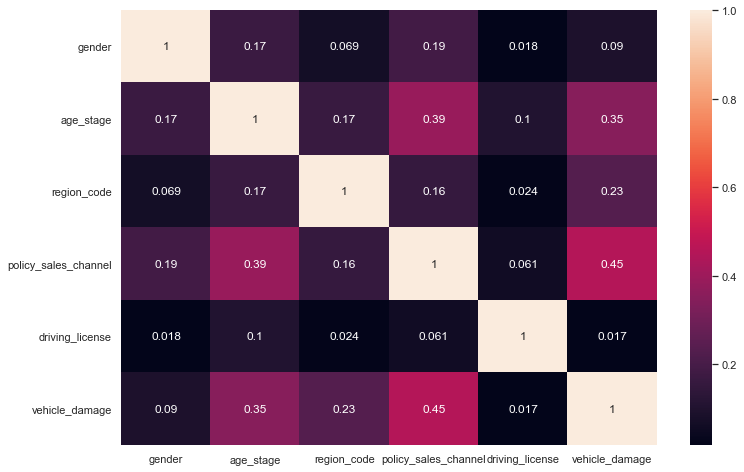

In [49]:
# list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append list
        corr_list.append(corr)
        
    # append correlation list for each ref attributes  
    corr_dict[ref] = corr_list
    
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
plt.figure(figsize=(12,8))
sns.heatmap(d, annot=True);

# 5.0 Data Filtering (Attributes with High Correlation)

In [50]:
cols_drop = ['age', 'vehicle_damage', 'annual_premium', 'vintage', 'driving_license']
df05 = df04.drop(cols_drop, axis=1)

#df05 = df04.copy() ### will be changed

# 6.0 Data Preparation

In [51]:
# Numerical
num_attributes = df05.select_dtypes(include=['int64', 'float64'])
# Categorical
cat_attributes = df05.select_dtypes(exclude=['int64', 'float64'])

## 6.1 Rescaling

## 6.2 Encoding

In [52]:
#age_stage -> Label Encoding
le = LabelEncoder()
cat_attributes['age_stage'] = le.fit_transform(cat_attributes['age_stage'])
#jb.dump(le,'../parameters/encoders/age_stage.pkl.z')

cat_attributes['gender'] = cat_attributes['gender'].apply(lambda row: 0 if row == 'Male' else 1)

df06 = pd.concat([num_attributes, cat_attributes], axis=1)

## 6.3 Transformation

# 7.0 Balanced

## 7.1 Split into Traing and Validation dataset

In [53]:
df06['region_code']          = df06['region_code'].astype(int)
df06['policy_sales_channel'] = df06['policy_sales_channel'].astype(int)

X = df06.drop('response', axis=1)
y = df06['response'].copy()


# Split into Train and Validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)

## 7.2 SMOTE & Tomeklink

In [54]:
ratio_balanced = {
                    0: 214015,
                    1: 7*29894
                }

ratio_balanced

{0: 214015, 1: 209258}

In [55]:
# define sampler
smt = SMOTETomek(sampling_strategy=ratio_balanced, random_state=9, n_jobs=-1)


# apply sampler
X_smt, y_smt = smt.fit_resample(X_train, y_train)

# 8.0 Feature Selection

## 8.1 Boruta as Feature Selector

In [56]:
# Training and Validation dataset for Boruta
X_train_n = X_smt.to_numpy()
y_train_n = y_smt.values.ravel()

# define RandomForestClassifier
#rf = RandomForestClassifier(n_jobs=-1)
#extra = ExtraTreesClassifier(n_jobs=-1)
xgb = XGBClassifier(n_jobs=-1,random_state=9, verbosity=0)

# define Boruta
boruta = BorutaPy(xgb, verbose=1, n_estimators='auto', random_state=9)
boruta.fit(X_train_n, y_train_n)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	0


BorutaPy(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                 colsample_bylevel=1, colsample_bynode=1,
                                 colsample_bytree=1, gamma=0, gpu_id=-1,
                                 importance_type='gain',
                                 interaction_constraints='',
                                 learning_rate=0.300000012, max_delta_step=0,
                                 max_depth=6, min_child_weight=1, missing=nan,
                                 monotone_constraints='()', n_estimators=84,
                                 n_jobs=-1, num_parallel_tree=1,
                                 random_state=1309284068, reg_alpha=0,
                                 reg_lambda=1, scale_pos_weight=1, subsample=1,
                                 tree_method='exact', validate_parameters=1,
                                 verbosity=0),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1E807417A40, ver

In [57]:
cols_selected = boruta.support_.tolist()

# Best Features
X_train_fs = X_smt
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

cols_not_select_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
cols_selected_boruta

['region_code',
 'policy_sales_channel',
 'vehicle_age',
 'previously_insured',
 'vehicle_damage_license',
 'vehicle_damage_vehicle_age',
 'age_mean_age_by_region_code',
 'age_mean_age_by_policy_sales_channel',
 'annual_premium_mean_annual_premium_by_region_code',
 'annual_premium_mean_annual_premium_by_policy_sales_channel',
 'age_vintage',
 'gender',
 'age_stage']

## 8.2 Shap

In [58]:
xgb = XGBClassifier(n_jobs=-1,random_state=9, verbosity=0)
xgb.fit(X_smt, y_smt)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=9,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

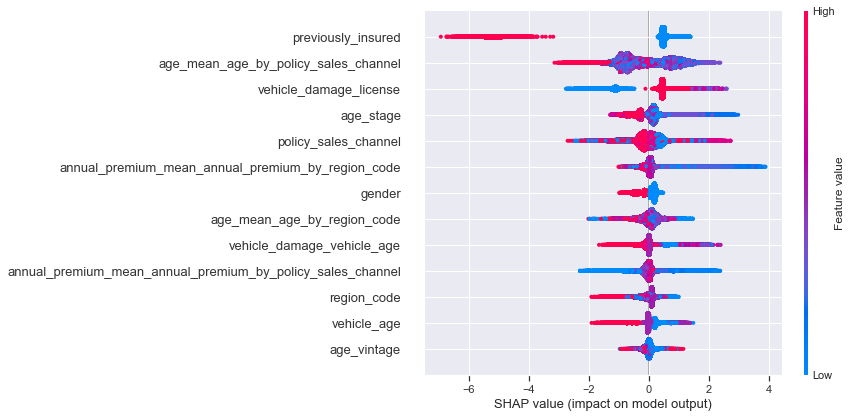

In [59]:
# print the JS visualization code to the notebook
shap.initjs()

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_smt)

shap.summary_plot(shap_values[:,:], X_smt)

## 8.3 Feature Filtering

In [60]:
cols_selected = ['region_code',
 'policy_sales_channel',
 'vehicle_age',
 'previously_insured',
 'vehicle_damage_license',
 'vehicle_damage_vehicle_age',
 'age_mean_age_by_region_code',
 'age_mean_age_by_policy_sales_channel',
 'annual_premium_mean_annual_premium_by_region_code',
 'annual_premium_mean_annual_premium_by_policy_sales_channel',
 'age_vintage',
 'gender',
 'age_stage']

X_train_smt = X_smt[cols_selected]
X_valid = X_valid[cols_selected]

# 9.0 Machine Learning Model

## 9.1 Baseline model

### 9.1.1 Random Choices

In [61]:
response_list = y_smt.drop_duplicates().sort_values().tolist()
response_weights = y_smt.value_counts(normalize=True).sort_index().tolist()
k_num = y_valid.shape[0]

# Random Model

yhat_random = random.choices(population=response_list,
                             weights=response_weights,
                             k=k_num)

### 9.1.2 Random Choices Performance

Accuracy: 0.4987536488569648
Balanced Accuracy: 0.49526102870333266
Kappa Score: -0.004083718177149365
              precision    recall  f1-score   support

           0       0.88      0.50      0.64     53504
           1       0.12      0.49      0.19      7474

    accuracy                           0.50     60978
   macro avg       0.50      0.50      0.41     60978
weighted avg       0.78      0.50      0.58     60978



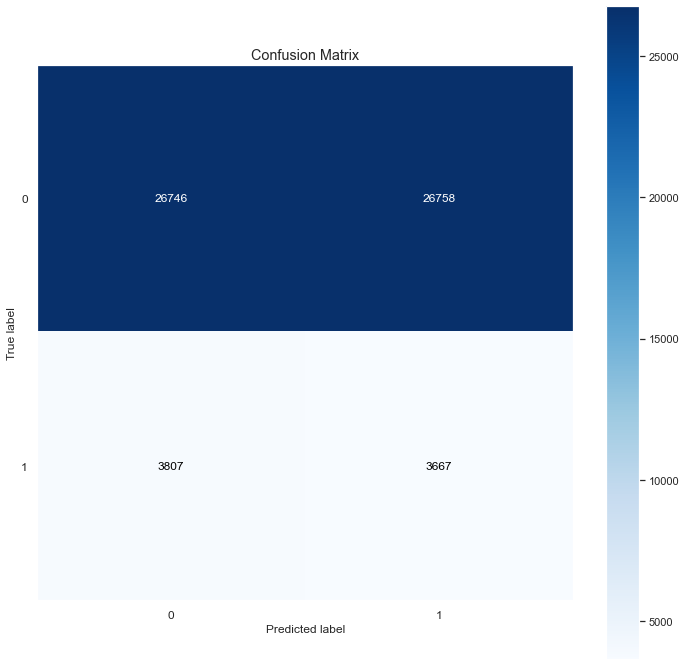

In [62]:
# Accuracy
acc_random = accuracy_score(y_valid, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = balanced_accuracy_score(y_valid, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Score
kappa_random = cohen_kappa_score(y_valid, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification Report
print(classification_report(y_valid, yhat_random))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_random, normalize=False, figsize=(12, 12));

## 9.2 Machine Learning Model

### 9.2.1 Random Forest

In [63]:
# Model
rf = RandomForestClassifier(n_jobs=-1, random_state=9)
rf.fit(X_train_smt, y_smt)

yhat_rf = rf.predict(X_valid)

#### 9.2.1.1 Performance

Accuracy: 0.8209518186887074
Balanced Accuracy: 0.6567635851534122
Kappa Score: 0.2735945085379289
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     53504
           1       0.33      0.44      0.38      7474

    accuracy                           0.82     60978
   macro avg       0.62      0.66      0.64     60978
weighted avg       0.85      0.82      0.83     60978



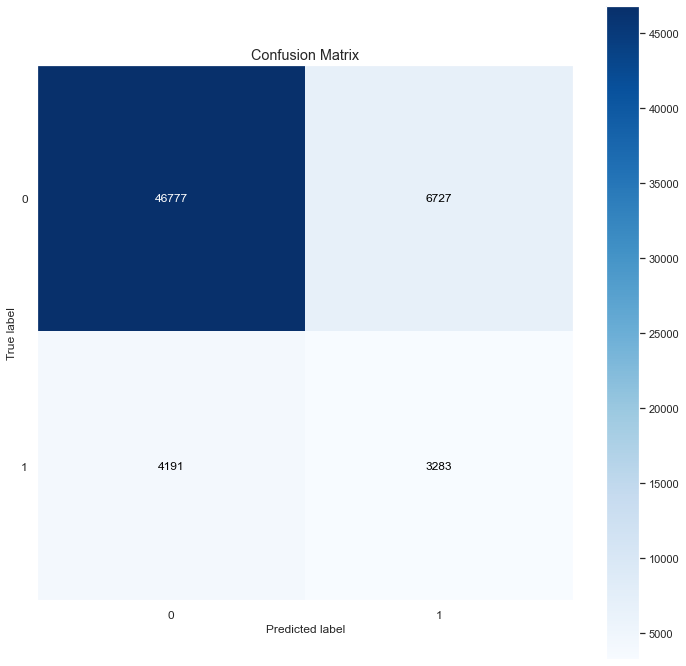

In [64]:
# Accuracy
acc_rf = accuracy_score(y_valid, yhat_rf)
print('Accuracy: {}'.format(acc_rf))

# Balanced Accuracy
balanced_acc_rf = balanced_accuracy_score(y_valid, yhat_rf)
print('Balanced Accuracy: {}'.format(balanced_acc_rf))

# Kappa Score
kappa_rf = cohen_kappa_score(y_valid, yhat_rf)
print('Kappa Score: {}'.format(kappa_rf))

# Classification Report
print(classification_report(y_valid, yhat_rf))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_rf, normalize=False, figsize=(12, 12));

#### 9.2.1.2 Performance - Cross Validation

In [65]:
# X and y dataset for Cross Validation
y_train_cv = pd.concat([y_train, y_valid], axis = 0)
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
X_train_cv = X_train_cv[cols_selected]

# model
model = RandomForestClassifier(n_jobs=-1, random_state=9)

# cross validation
result_rf = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, is_unbalance=True, verbose=True)
result_rf

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,RandomForestClassifier,0.3299 +/- 0.0014,0.4342 +/- 0.0027,0.3749 +/- 0.0018,0.2737 +/- 0.002,0.6555 +/- 0.0013,0.321 +/- 0.0014,0.8343 +/- 0.0009


### 9.2.2 XGBoost Classifier

In [66]:
xgb = XGBClassifier(max_depth=2, n_jobs=-1, random_state=9, verbosity=0)
xgb.fit(X_train_smt, y_smt)

# Prediction
yhat_xgb = xgb.predict(X_valid)

#### 9.2.2.1 Performance

Accuracy: 0.7490242382498606
Balanced Accuracy: 0.7680625195454289
Kappa Score: 0.31481983193552043
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     53504
           1       0.30      0.79      0.44      7474

    accuracy                           0.75     60978
   macro avg       0.63      0.77      0.64     60978
weighted avg       0.88      0.75      0.79     60978



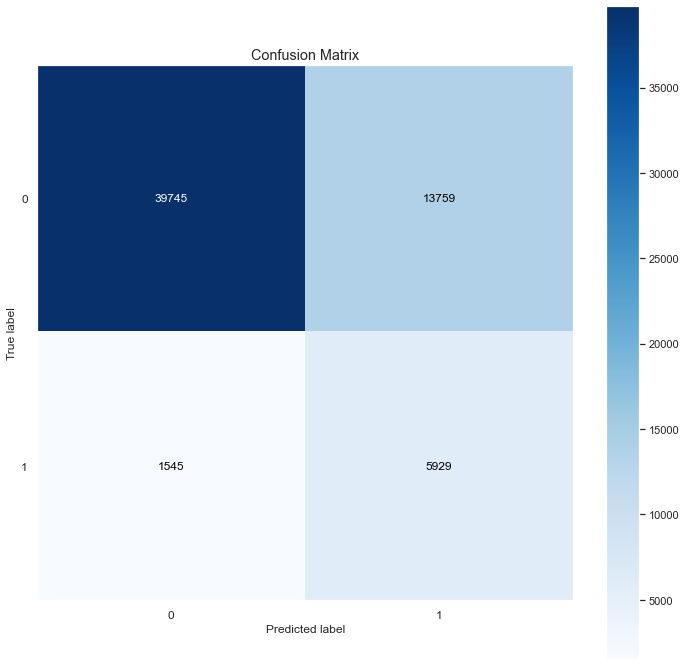

In [67]:
# Accuracy
acc_xgb = accuracy_score(y_valid, yhat_xgb)
print('Accuracy: {}'.format(acc_xgb))

# Balanced Accuracy
balanced_acc_xgb = balanced_accuracy_score(y_valid, yhat_xgb)
print('Balanced Accuracy: {}'.format(balanced_acc_xgb))

# Kappa Score
kappa_xgb = cohen_kappa_score(y_valid, yhat_xgb)
print('Kappa Score: {}'.format(kappa_xgb))

# Classification Report
print(classification_report(y_valid, yhat_xgb))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_xgb, normalize=False, figsize=(12, 12));

#### 9.2.2.2 Performance - Cross Validation

In [68]:
# X and y dataset for Cross Validation
y_train_cv = pd.concat([y_train, y_valid], axis = 0)
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
X_train_cv = X_train_cv[cols_selected]

# model
model = XGBClassifier(n_jobs=-1, random_state=9, verbosity=0)

# cross validation
result_xgb = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, is_unbalance=True, verbose=True)
result_xgb

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,XGBClassifier,0.3305 +/- 0.0017,0.5754 +/- 0.0057,0.4198 +/- 0.002,0.3128 +/- 0.0023,0.7063 +/- 0.0021,0.3352 +/- 0.001,0.844 +/- 0.0013


### 9.2.3 LightGBM Classifier

In [69]:
lgbm = LGBMClassifier(n_jobs=-1, random_state=9)
lgbm.fit(X_train_smt, y_smt)

# Prediction
yhat_lgbm = lgbm.predict(X_valid)

#### 9.2.3.1 Performance

Accuracy: 0.7826265210403752
Balanced Accuracy: 0.7426066689283615
Kappa Score: 0.3243787842948612
              precision    recall  f1-score   support

           0       0.95      0.80      0.87     53504
           1       0.32      0.69      0.44      7474

    accuracy                           0.78     60978
   macro avg       0.63      0.74      0.65     60978
weighted avg       0.87      0.78      0.81     60978



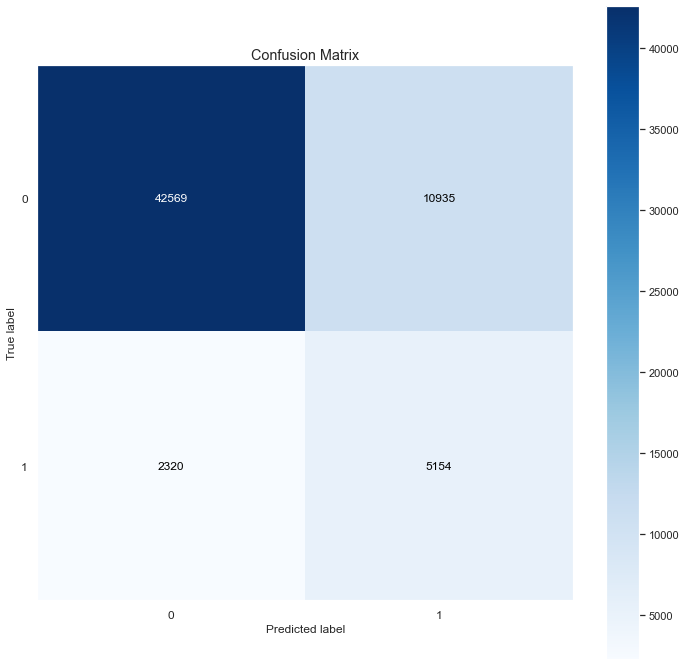

In [70]:
# Accuracy
acc_lgbm = accuracy_score(y_valid, yhat_lgbm)
print('Accuracy: {}'.format(acc_lgbm))

# Balanced Accuracy
balanced_acc_lgbm = balanced_accuracy_score(y_valid, yhat_lgbm)
print('Balanced Accuracy: {}'.format(balanced_acc_lgbm))

# Kappa Score
kappa_lgbm = cohen_kappa_score(y_valid, yhat_lgbm)
print('Kappa Score: {}'.format(kappa_lgbm))

# Classification Report
print(classification_report(y_valid, yhat_lgbm))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_lgbm, normalize=False, figsize=(12, 12));

#### 9.2.3.2 Performance - Cross Validation

In [71]:
# X and y dataset for Cross Validation
y_train_cv = pd.concat([y_train, y_valid], axis = 0)
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
X_train_cv = X_train_cv[cols_selected]

# model
model = LGBMClassifier(n_jobs=-1, random_state=9)

# cross validation
result_lgbm = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, is_unbalance=True, verbose=True)
result_lgbm

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,LGBMClassifier,0.3179 +/- 0.0019,0.7209 +/- 0.0083,0.4412 +/- 0.0029,0.3267 +/- 0.0033,0.7524 +/- 0.0034,0.3406 +/- 0.001,0.8457 +/- 0.0013


### 9.2.4 Catboost Classifier

In [72]:
catb = CatBoostClassifier(random_state=9, verbose=False)
catb.fit(X_smt, y_smt)

# Prediction
yhat_catb = catb.predict(X_valid)

#### 9.2.4.1 Performance

Accuracy: 0.8241332939748762
Balanced Accuracy: 0.6686483937778558
Kappa Score: 0.29204854311425277
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     53504
           1       0.34      0.46      0.39      7474

    accuracy                           0.82     60978
   macro avg       0.63      0.67      0.64     60978
weighted avg       0.85      0.82      0.84     60978



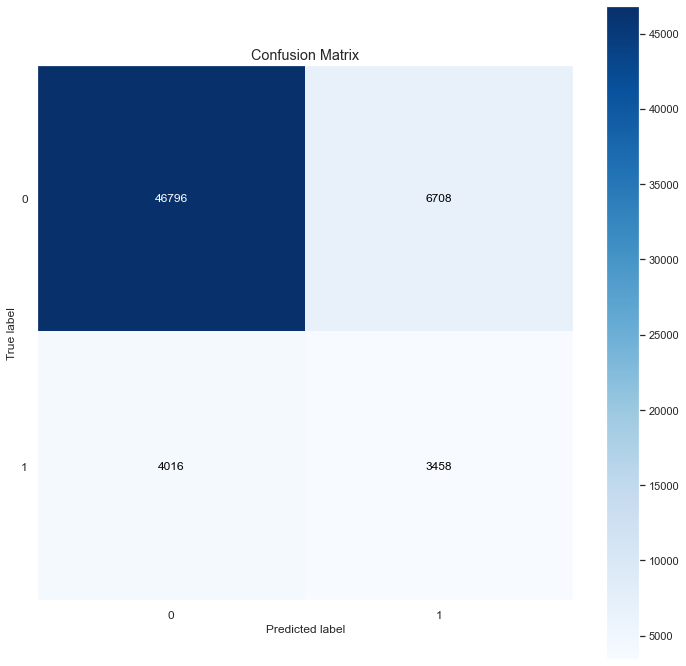

In [73]:
# Accuracy
acc_catb = accuracy_score(y_valid, yhat_catb)
print('Accuracy: {}'.format(acc_catb))

# Balanced Accuracy
balanced_acc_catb = balanced_accuracy_score(y_valid, yhat_catb)
print('Balanced Accuracy: {}'.format(balanced_acc_catb))

# Kappa Score
kappa_catb = cohen_kappa_score(y_valid, yhat_catb)
print('Kappa Score: {}'.format(kappa_catb))

# Classification Report
print(classification_report(y_valid, yhat_catb))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_catb, normalize=False, figsize=(12, 12));

#### 9.2.4.2 Performance - Cross Validation

In [74]:
# X and y dataset for Cross Validation
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
y_train_cv = pd.concat([y_train, y_valid], axis = 0)

# model
model = CatBoostClassifier(random_state=9, verbose = False)

# cross validation
result_catb = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, is_unbalance=True, verbose=True)
result_catb

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,CatBoostClassifier,0.3363 +/- 0.0029,0.5373 +/- 0.0068,0.4137 +/- 0.0034,0.3096 +/- 0.0039,0.6946 +/- 0.0029,0.3407 +/- 0.0026,0.8451 +/- 0.0015


### 9.2.5 Logistic Regression

In [75]:
lr = LogisticRegression(max_iter=220, random_state=9)
lr.fit(X_smt, y_smt)

# Prediction
yhat_lr = lr.predict(X_valid)

#### 9.2.5.1 Performance

Accuracy: 0.6932500245990357
Balanced Accuracy: 0.7790420892307047
Kappa Score: 0.2812609335244224
              precision    recall  f1-score   support

           0       0.98      0.67      0.79     53504
           1       0.27      0.89      0.42      7474

    accuracy                           0.69     60978
   macro avg       0.62      0.78      0.60     60978
weighted avg       0.89      0.69      0.75     60978



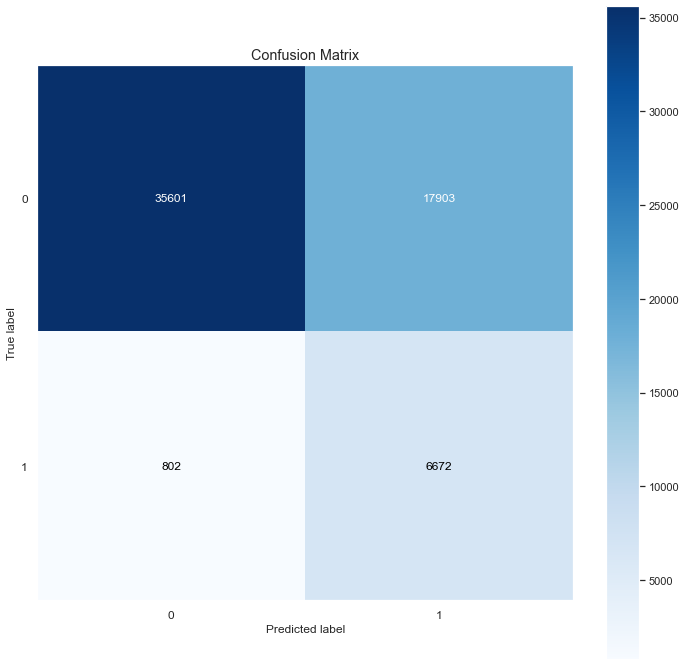

In [76]:
# Accuracy
acc_lr = accuracy_score(y_valid, yhat_lr)
print('Accuracy: {}'.format(acc_lr))

# Balanced Accuracy
balanced_acc_lr = balanced_accuracy_score(y_valid, yhat_lr)
print('Balanced Accuracy: {}'.format(balanced_acc_lr))

# Kappa Score
kappa_lr = cohen_kappa_score(y_valid, yhat_lr)
print('Kappa Score: {}'.format(kappa_lr))

# Classification Report
print(classification_report(y_valid, yhat_lr))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_lr, normalize=False, figsize=(12, 12));

#### 9.2.5.2 Performance - Cross Validation

In [77]:
# X and y dataset for Cross Validation
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
y_train_cv = pd.concat([y_train, y_valid], axis = 0)

# model
model = LogisticRegression(max_iter=400, random_state=9)

# cross validation
result_lr = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, is_unbalance=True, verbose=True)
result_lr

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,LogisticRegression,0.2729 +/- 0.0013,0.8947 +/- 0.0076,0.4183 +/- 0.0015,0.2837 +/- 0.002,0.7809 +/- 0.0023,0.3183 +/- 0.0018,0.8334 +/- 0.0008


### 9.2.6 KNN

In [78]:
knn = KNeighborsClassifier()
knn.fit(X_smt, y_smt)

# Prediction
yhat_knn = knn.predict(X_valid)

#### 9.2.6.1 Performance

Accuracy: 0.7402177834628882
Balanced Accuracy: 0.6879369038544145
Kappa Score: 0.23734652918625487
              precision    recall  f1-score   support

           0       0.93      0.76      0.84     53504
           1       0.26      0.62      0.37      7474

    accuracy                           0.74     60978
   macro avg       0.60      0.69      0.60     60978
weighted avg       0.85      0.74      0.78     60978



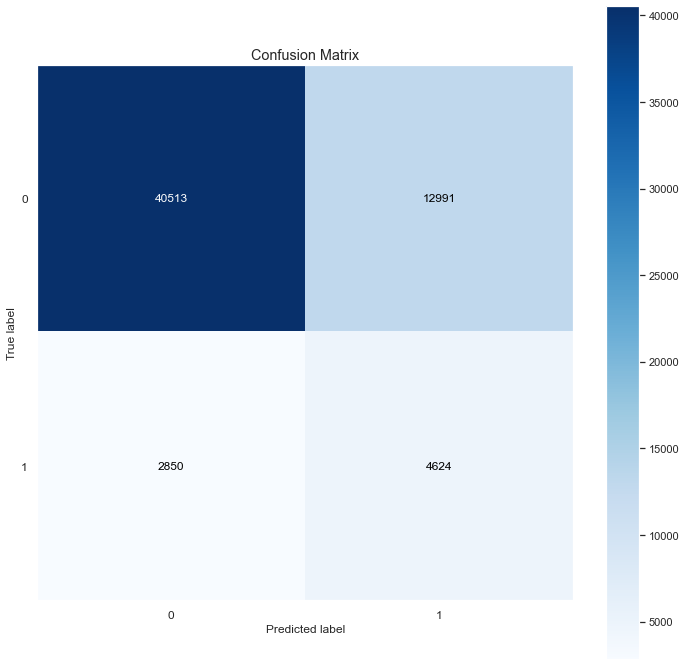

In [79]:
# Accuracy
acc_knn = accuracy_score(y_valid, yhat_knn)
print('Accuracy: {}'.format(acc_knn))

# Balanced Accuracy
balanced_acc_knn = balanced_accuracy_score(y_valid, yhat_knn)
print('Balanced Accuracy: {}'.format(balanced_acc_knn))

# Kappa Score
kappa_knn = cohen_kappa_score(y_valid, yhat_knn)
print('Kappa Score: {}'.format(kappa_knn))

# Classification Report
print(classification_report(y_valid, yhat_knn))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_knn, normalize=False, figsize=(12, 12));

#### 9.2.6.2 Performance - Cross Validation

In [80]:
# X and y dataset for Cross Validation
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
y_train_cv = pd.concat([y_train, y_valid], axis = 0)

# model
model = KNeighborsClassifier()

# cross validation
result_knn = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, is_unbalance=True, verbose=True)
result_knn

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,KNeighborsClassifier,0.266 +/- 0.0038,0.5926 +/- 0.0105,0.3672 +/- 0.0055,0.2383 +/- 0.0065,0.6821 +/- 0.0053,0.2432 +/- 0.0041,0.7462 +/- 0.0042


### 9.2.7 Performance Comparison 

In [81]:
df_compare = pd.concat([result_rf, result_xgb, result_lgbm, result_catb, result_lr, result_knn], axis=0).reset_index(drop=True)
df_compare

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,RandomForestClassifier,0.3299 +/- 0.0014,0.4342 +/- 0.0027,0.3749 +/- 0.0018,0.2737 +/- 0.002,0.6555 +/- 0.0013,0.321 +/- 0.0014,0.8343 +/- 0.0009
1,XGBClassifier,0.3305 +/- 0.0017,0.5754 +/- 0.0057,0.4198 +/- 0.002,0.3128 +/- 0.0023,0.7063 +/- 0.0021,0.3352 +/- 0.001,0.844 +/- 0.0013
2,LGBMClassifier,0.3179 +/- 0.0019,0.7209 +/- 0.0083,0.4412 +/- 0.0029,0.3267 +/- 0.0033,0.7524 +/- 0.0034,0.3406 +/- 0.001,0.8457 +/- 0.0013
3,CatBoostClassifier,0.3363 +/- 0.0029,0.5373 +/- 0.0068,0.4137 +/- 0.0034,0.3096 +/- 0.0039,0.6946 +/- 0.0029,0.3407 +/- 0.0026,0.8451 +/- 0.0015
4,LogisticRegression,0.2729 +/- 0.0013,0.8947 +/- 0.0076,0.4183 +/- 0.0015,0.2837 +/- 0.002,0.7809 +/- 0.0023,0.3183 +/- 0.0018,0.8334 +/- 0.0008
5,KNeighborsClassifier,0.266 +/- 0.0038,0.5926 +/- 0.0105,0.3672 +/- 0.0055,0.2383 +/- 0.0065,0.6821 +/- 0.0053,0.2432 +/- 0.0041,0.7462 +/- 0.0042


# 10.0 Hyperparameter Fine Tuning

- XGBoost
- Lightgbm

## 10.1 XGBoost Classifier

In [82]:
df_results_xgb = pd.DataFrame()

def tune_xgb(params):
    print(params)
    learning_rate     = params[0]
    max_depth         = params[1]
    min_child_weight  = params[2]
    subsample         = params[3]
    colsample_bytree  = params[4]
    n_estimators      = params[5]
    gamma             = params[6]

    # Model
    model = XGBClassifier(learning_rate=learning_rate, num_leaves=2 ** max_depth, max_depth=max_depth, min_child_weight=min_child_weight,
                                    subsample=subsample, colsample_bytree=colsample_bytree, n_estimators=n_estimators, gamma=gamma,
                                    booster='gbtree', importance_type='gain', tree_method='exact',
                                    bagging_freq=1, random_state=9, n_jobs=-1, verbosity=0)

    model.fit(X_train_smt, y_smt)

    # Model Name
    model_name = type(model).__name__

    # Prediction
    yhat = model.predict(X_valid)

    # Prediction Proba
    yhat_proba = model.predict_proba(X_valid)[:,1]
    # Performance
    roc_auc = roc_auc_score(y_valid, yhat_proba)
    
    return -roc_auc


space = [(1e-3, 3e-2, 'log-uniform'), # lr
        (10, 17), # max_depth
        (10, 20), # min_child_weight
        (0.05, 1), # subsample
        (0.05, 0.5), # colsample_bytree
        (100, 500), # n_estimetors
        (1.0, 6.0)]# #gamma


result = forest_minimize(tune_xgb, space, random_state=9, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.0034542448927724315, 15, 16, 0.05716594068063828, 0.19230093854628494, 165, 2.0927933781303913]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 19.6256
Function value obtained: -0.8394
Current minimum: -0.8394
Iteration No: 2 started. Evaluating function at random point.
[0.004151330676373718, 12, 11, 0.1298566686070826, 0.2054743880226801, 321, 2.57854433650371]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 41.0878
Function value obtained: -0.8406
Current minimum: -0.8406
Iteration No: 3 started. Evaluating function at random point.
[0.0035675596087566437, 13, 18, 0.9695088771294953, 0.36569680093036533, 334, 5.490035591125749]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 123.0952
Function value obtained: -0.8462
Current minimum: -0.8462
Iteration No: 4 started. Evaluating function at random point.
[0.009662525379690227, 16, 18, 0.7173060528646525, 0.223914

In [83]:
result_list_xgb = result.x
result_list_xgb

[0.00535001230205099,
 14,
 12,
 0.5442963472722957,
 0.4563597179737713,
 385,
 3.840406504328821]

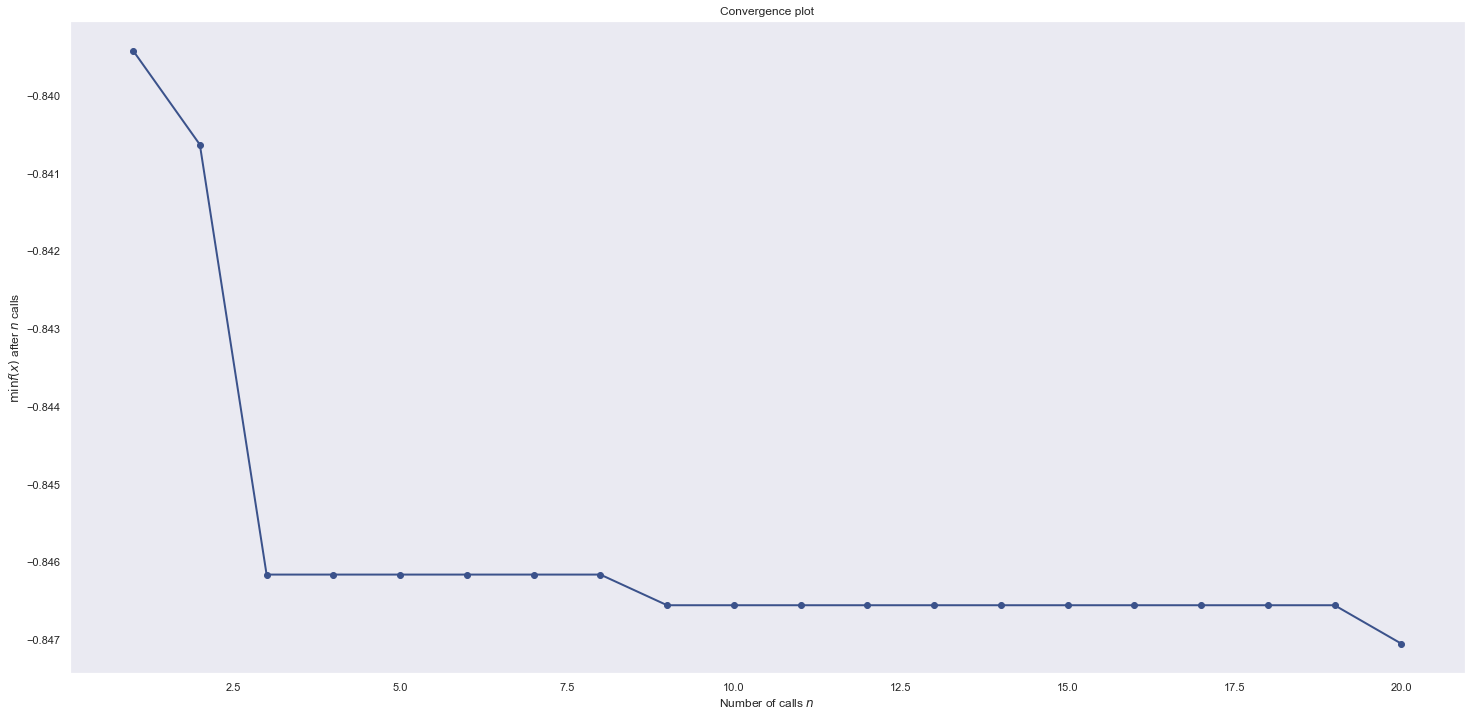

In [84]:
plot_convergence(result);

## 10.2 Lightgbm Classifier

In [85]:
df_results_lgbm = pd.DataFrame()

def tune_lgbm(params):
    print(params)
    learning_rate     = params[0]
    max_depth         = params[1]
    min_child_samples = params[2]
    subsample         = params[3]
    colsample_bytree  = params[4]
    n_estimators      = params[5]
        
    # Model
    model = LGBMClassifier(learning_rate=learning_rate, num_leaves=2 ** max_depth, max_depth=max_depth, min_child_samples=min_child_samples,
                                    subsample=subsample, colsample_bytree=colsample_bytree, n_estimators=n_estimators,
                                    random_state=9, n_jobs=-1, boosting_type='gbdt', importance_type='gain',
                                    objective='binary',metric='auc')


    model.fit(X_train_smt, y_smt)

    # Model Name
    model_name = type(model).__name__

    # Prediction
    yhat = model.predict(X_valid)

    # Prediction Proba
    yhat_proba = model.predict_proba(X_valid)[:,1]
    # Performance
    roc_auc = roc_auc_score(y_valid, yhat_proba)
    
    return -roc_auc


space = [(5e-3, 3e-2, 'log-uniform'), # lr
        (12, 17), # max_depth
        (13, 20), # min_child_samples
        (0.5, 1), # subsample
        (0.05, 0.5), # colsample_bytree
        (150, 500)] # n_estimetors


result = forest_minimize(tune_lgbm, space, random_state=9, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.009606734877379371, 17, 19, 0.5037715477266518, 0.19230093854628494, 215]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 164.0793
Function value obtained: -0.8370
Current minimum: -0.8370
Iteration No: 2 started. Evaluating function at random point.
[0.007396763125692112, 15, 13, 0.6240505842067796, 0.08782684302440755, 497]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 15.4333
Function value obtained: -0.8311
Current minimum: -0.8370
Iteration No: 3 started. Evaluating function at random point.
[0.012130704785279445, 16, 13, 0.6869755907020123, 0.3805961181777475, 468]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 206.2967
Function value obtained: -0.8449
Current minimum: -0.8449
Iteration No: 4 started. Evaluating function at random point.
[0.006373107642990084, 12, 17, 0.9754035791301645, 0.29887505893478056, 377]
Iteration No: 4 ended. Evaluation done at

In [86]:
result_list_lgbm = result.x
result_list_lgbm
# [0.012003724009649733, 14, 13, 0.5164306854237872, 0.2489934874161357, 396] - 0.8441
# [0.02073731316483599, 16, 16, 0.09070909251385395, 0.21160843363860826, 161] - 0.8439
# [0.0075765800185707, 14, 20, 0.876613053030145, 0.38653410718663495, 447] - 0.8447
# [0.015447418916483038, 15, 19, 0.8197841177346874, 0.3942582780363857, 199] - 0.8447

[0.023911562857022988, 12, 13, 0.8791389933983245, 0.20610587919898388, 174]

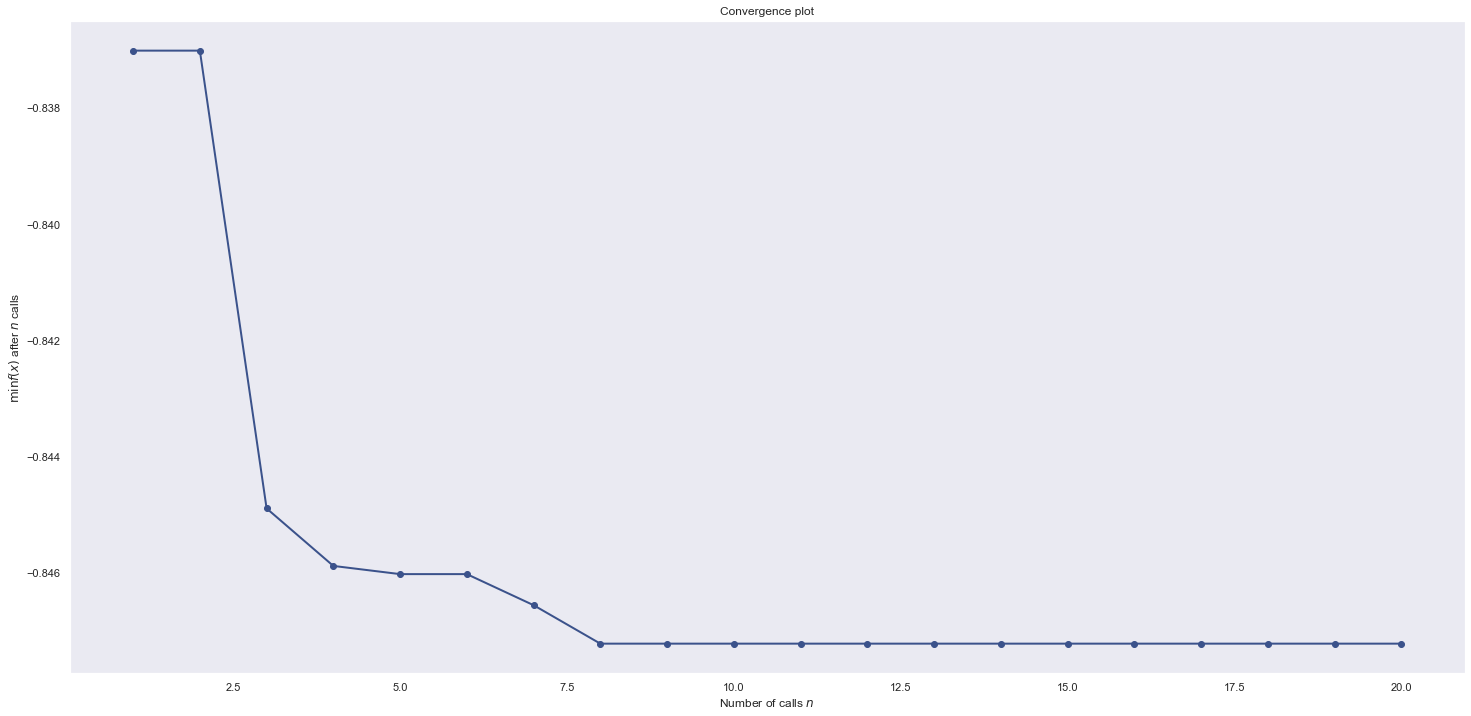

In [87]:
plot_convergence(result);

# 11.0 Final Model

- XGBoost
- Lightgbm

## 11.1 XGBoost Classifier

In [88]:
params_xgb = result_list_xgb

lr                = params_xgb[0]
max_depth         = params_xgb[1]
min_child_weight  = params_xgb[2]
subsample         = params_xgb[3]
colsample_bytree  = params_xgb[4]
n_estimators      = params_xgb[5]
gamma             = params_xgb[6]
# reg_lambda        = params_xgb[7]
# reg_alpha         = params_xgb[8]

#[0.023230148647550936, 3, 1, 0.3140586401000465, 0.37388940456063163, 650, 0.4269876463197445]
#Model
xgb = XGBClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, min_child_weight=min_child_weight,
                    subsample=subsample, colsample_bytree=colsample_bytree, n_estimators=n_estimators, gamma=gamma, #reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                     booster='gbtree', importance_type='gain', tree_method='exact', bagging_freq=1, random_state=0, n_jobs=-1, verbosity=0)


xgb.fit(X_smt, y_smt)

# Prediction
yhat_xgb = xgb.predict(X_valid)

# Prediction proba
yhat_proba_xgb = xgb.predict_proba(X_valid)[:,1]

### 11.1.1 Performance

In [89]:
# Model Name
model_name = type(xgb).__name__

# Scores
final_scores = ml_scores(model_name, y_valid, yhat_xgb, yhat_proba_xgb)
final_scores.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,XGBClassifier,0.31774,0.735215,0.443718,0.328838,0.757345,0.340237,0.846384


              precision    recall  f1-score   support

           0       0.95      0.78      0.86     53504
           1       0.32      0.74      0.44      7474

    accuracy                           0.77     60978
   macro avg       0.64      0.76      0.65     60978
weighted avg       0.88      0.77      0.81     60978



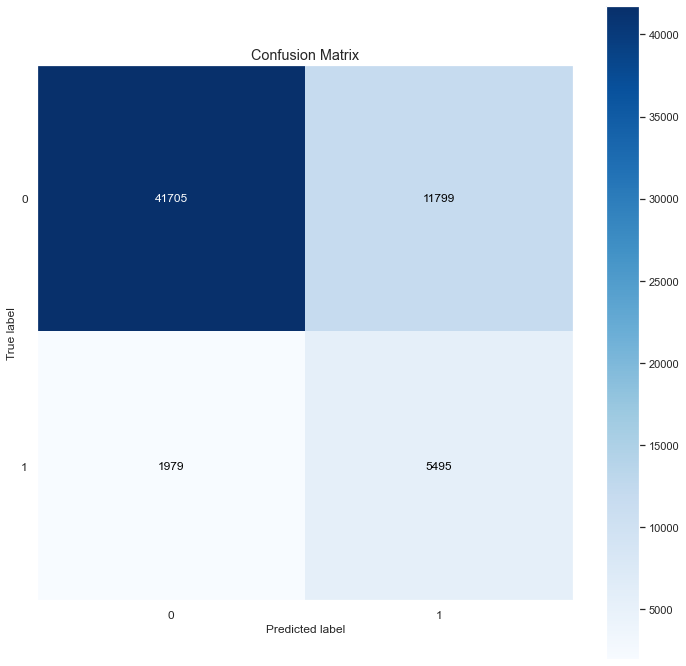

In [90]:
# Classification Report
print(classification_report(y_valid, yhat_xgb))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_xgb, normalize=False, figsize=(12, 12));

### 11.1.2 Performance - Cross Validation

In [91]:
# X and y dataset for Cross Validation
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
y_train_cv = pd.concat([y_train, y_valid], axis = 0)

# model
model = XGBClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, min_child_weight=min_child_weight,
                    subsample=subsample, colsample_bytree=colsample_bytree, n_estimators=n_estimators, gamma=gamma, #reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                     booster='gbtree', importance_type='gain', tree_method='exact', bagging_freq=1, random_state=0, n_jobs=-1, verbosity=0)

# cross validation
result_xgb = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, is_unbalance=True, verbose=True)
result_xgb

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,XGBClassifier,0.3219 +/- 0.0013,0.7353 +/- 0.0047,0.4477 +/- 0.0015,0.3342 +/- 0.0019,0.7594 +/- 0.0018,0.3443 +/- 0.0021,0.8482 +/- 0.001


## 11.2 LightGBM Classifier

In [92]:
params_lgbm = result_list_lgbm


learning_rate     = params_lgbm[0]
max_depth         = params_lgbm[1]
min_child_samples = params_lgbm[2]
subsample         = params_lgbm[3]
colsample_bytree  = params_lgbm[4]
n_estimators      = params_lgbm[5]
        
#Model
lgbm = LGBMClassifier(learning_rate=learning_rate, num_leaves=2 ** max_depth, max_depth=max_depth, min_child_samples=min_child_samples,
                                subsample=subsample, colsample_bytree=colsample_bytree, n_estimators=n_estimators,# reg_lambda=reg_lambda,
                                #reg_alpha=reg_alpha,
                                random_state=9, n_jobs=-1, boosting_type='gbdt',importance_type='gain',
                                objective='binary',metric='auc')


lgbm.fit(X_smt, y_smt)

# Prediction
yhat_lgbm = lgbm.predict(X_valid)

# Prediction proba
yhat_proba_lgbm = lgbm.predict_proba(X_valid)[:,1]

### 11.2.1 Performance

In [93]:
# Model Name
model_name = type(lgbm).__name__

# Scores
final_scores = ml_scores(model_name, y_valid, yhat_lgbm, yhat_proba_lgbm)
final_scores.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,LGBMClassifier,0.317062,0.74913,0.44555,0.330181,0.761863,0.341068,0.847214


              precision    recall  f1-score   support

           0       0.96      0.77      0.86     53504
           1       0.32      0.75      0.45      7474

    accuracy                           0.77     60978
   macro avg       0.64      0.76      0.65     60978
weighted avg       0.88      0.77      0.81     60978



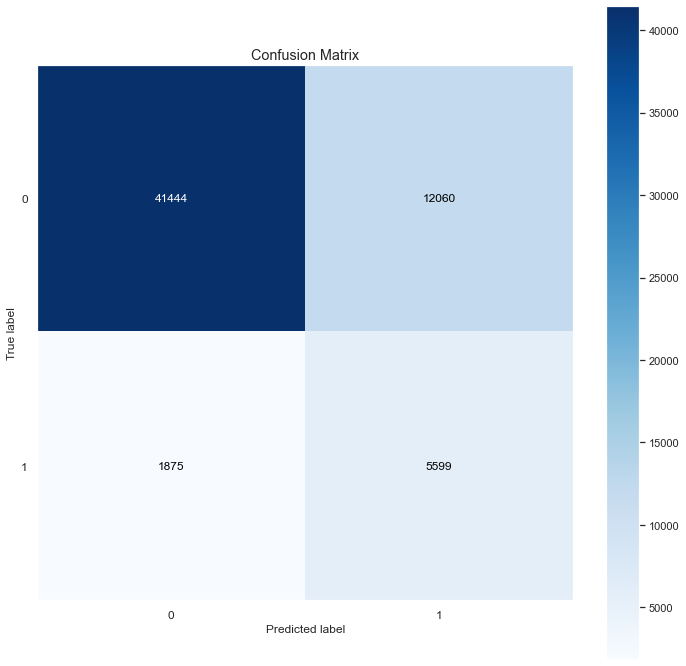

In [94]:
# Classification Report
print(classification_report(y_valid, yhat_lgbm))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_lgbm, normalize=False, figsize=(12, 12));

### 11.2.2 Performance - Cross Validation

In [95]:
# X and y dataset for Cross Validation
X_train_cv = pd.concat([X_train, X_valid], axis = 0)
y_train_cv = pd.concat([y_train, y_valid], axis = 0)

# model
model = LGBMClassifier(learning_rate=learning_rate, num_leaves=2 ** max_depth, max_depth=max_depth, min_child_samples=min_child_samples,
                                subsample=subsample, colsample_bytree=colsample_bytree, n_estimators=n_estimators,# reg_lambda=reg_lambda,
                                #reg_alpha=reg_alpha,
                                random_state=9, n_jobs=-1, boosting_type='gbdt',importance_type='gain',
                                objective='binary',metric='auc')


# cross validation
result_lgbm = cross_validation(X_train_cv, y_train_cv, model, num_folds=5, is_unbalance=True, verbose=True)
result_lgbm

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,LGBMClassifier,0.3188 +/- 0.0011,0.7528 +/- 0.0039,0.4479 +/- 0.0015,0.333 +/- 0.0018,0.764 +/- 0.0016,0.3454 +/- 0.0013,0.8485 +/- 0.0008


## 11.3 Models Compare

In [96]:
df_compare = pd.concat([result_xgb, result_lgbm], axis=0).reset_index(drop=True)
df_compare

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,XGBClassifier,0.3219 +/- 0.0013,0.7353 +/- 0.0047,0.4477 +/- 0.0015,0.3342 +/- 0.0019,0.7594 +/- 0.0018,0.3443 +/- 0.0021,0.8482 +/- 0.001
1,LGBMClassifier,0.3188 +/- 0.0011,0.7528 +/- 0.0039,0.4479 +/- 0.0015,0.333 +/- 0.0018,0.764 +/- 0.0016,0.3454 +/- 0.0013,0.8485 +/- 0.0008


## 11.4 Final Model Evaluation

In [97]:
####### Teste
df_test = pd.read_feather('../data/interim/test_data.feather')


#====================================================== feature Engineering ======================================================#
# Age Stage
df_test['age_stage'] = df_test['age'].apply(lambda row: age_stage(row))

# vehicle age
vehicle_age_mapping = {'< 1 Year':0,
                       '1-2 Year':1,
                       '> 2 Years':2}

df_test['vehicle_age'] = df_test['vehicle_age'].map(vehicle_age_mapping)

# vehicle demage versus license
vehicle_damage_mapping = {'No':0,
                          'Yes':1}

df_test['vehicle_damage'] = df_test['vehicle_damage'].map(vehicle_damage_mapping)
df_test['vehicle_damage_license'] = df_test.apply(lambda row: -(row['vehicle_damage'] + row['driving_license'])**2 if row['driving_license'] == 0 else (row['vehicle_damage'] + row['driving_license'])**2, axis=1)


# vehicle_damage_vehicle_age
df_test['vehicle_damage_vehicle_age'] = df_test.apply(lambda row: -(row['vehicle_damage'] + row['vehicle_age'])**2 if row['vehicle_damage'] == 1 else (row['vehicle_damage'] + row['vehicle_age'])**2, axis=1)

# age / mean_age_by_region_code
region_code_mean_age = pd.DataFrame(df_test.groupby('region_code')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_region_code'})
df_test = pd.merge(df_test, region_code_mean_age, how='left', on='region_code')

df_test['age_mean_age_by_region_code'] = df_test['age'] / df_test['mean_age_by_region_code']
del region_code_mean_age


# age / mean_age_by_policy_sales_channel
policy_sales_channel_mean_age = pd.DataFrame(df_test.groupby('policy_sales_channel')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_policy_sales_channel'})
df_test = pd.merge(df_test, policy_sales_channel_mean_age, how='left', on='policy_sales_channel')

df_test['age_mean_age_by_policy_sales_channel'] = df_test['age'] / df_test['mean_age_by_policy_sales_channel']
del policy_sales_channel_mean_age


# annual_premium / mean_annual_premium_by_region_code
region_code_mean_annual_premium = pd.DataFrame(df_test.groupby('region_code')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_region_code'})
df_test = pd.merge(df_test, region_code_mean_annual_premium, how='left', on='region_code')

df_test['annual_premium_mean_annual_premium_by_region_code'] = df_test['annual_premium'] / df_test['mean_annual_premium_by_region_code']
del region_code_mean_annual_premium


# annual_premium / mean_annual_premium_by_policy_sales_channel
policy_sales_channel_mean_annual_premium = pd.DataFrame(df_test.groupby('policy_sales_channel')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_policy_sales_channel'})
df_test = pd.merge(df_test, policy_sales_channel_mean_annual_premium, how='left', on='policy_sales_channel')

df_test['annual_premium_mean_annual_premium_by_policy_sales_channel'] = df_test['annual_premium'] / df_test['mean_annual_premium_by_policy_sales_channel']
del policy_sales_channel_mean_annual_premium

# age / vintage
df_test['age_vintage'] = (df_test['age']*365) / df_test['vintage']


#====================================================== Data Preparation ======================================================#

# Numerical
num_attributes_teste = df_test.select_dtypes(include=['int64', 'float64'])
# Categorical
cat_attributes_teste = df_test.select_dtypes(exclude=['int64', 'float64'])


# # Dummy variable
# df_teste_dummy = pd.get_dummies(cat_attributes_teste)

# # Join id and country_destination
# df_teste = pd.concat([num_attributes_teste, df_teste_dummy], axis=1)

#age_stage -> Label Encoding
cat_attributes_teste['age_stage'] = le.fit_transform(cat_attributes_teste['age_stage'])

cat_attributes_teste['gender'] = cat_attributes_teste['gender'].apply(lambda row: 0 if row == 'Male' else 1)

df_teste = pd.concat([num_attributes_teste, cat_attributes_teste], axis=1)



X_test_eval = df_teste[cols_selected]
y_test_eval = df_teste['response'].copy()

### XGBoost

In [98]:
# Prediction
yhat_xgb_eval = xgb.predict(X_test_eval)

# Prediction proba
yhat_proba_xgb_eval = xgb.predict_proba(X_test_eval)[:,1]
yhat_proba_xgb_eval_2 = xgb.predict_proba(X_test_eval)

In [99]:
# Model Name
model_name = type(xgb).__name__

# Scores
final_scores = ml_scores(model_name, y_test_eval, yhat_xgb_eval, yhat_proba_xgb_eval)
final_scores.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,XGBClassifier,0.269945,0.90152,0.415481,0.27958,0.780477,0.308656,0.831489


              precision    recall  f1-score   support

           0       0.98      0.66      0.79     66880
           1       0.27      0.90      0.42      9342

    accuracy                           0.69     76222
   macro avg       0.62      0.78      0.60     76222
weighted avg       0.89      0.69      0.74     76222



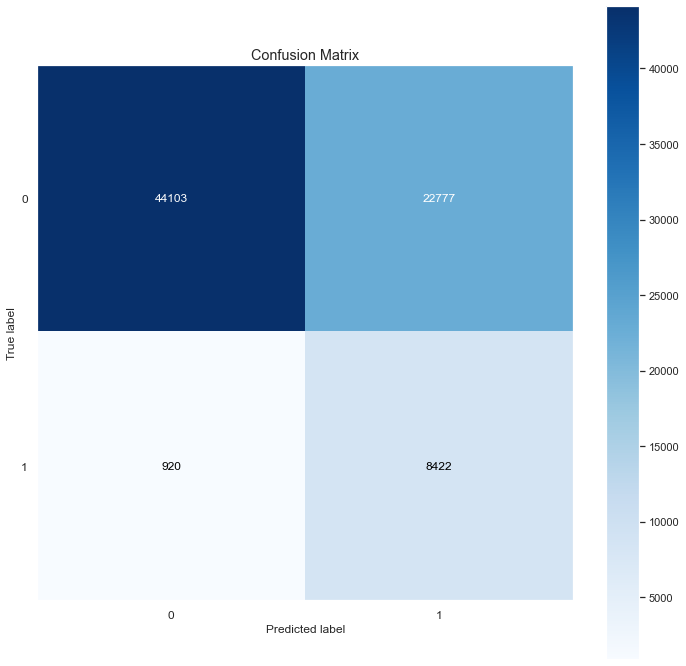

In [100]:
# Classification Report
print(classification_report(y_test_eval, yhat_xgb_eval))

# Confusion matrix
plot_confusion_matrix(y_test_eval, yhat_xgb_eval, normalize=False, figsize=(12, 12));

### 12.4.2 LightGBM Classifier

In [101]:
# Prediction
yhat_lgbm_eval = lgbm.predict(X_test_eval)

# Prediction proba
yhat_proba_lgbm_eval = lgbm.predict_proba(X_test_eval)[:,1]
yhat_proba_lgbm_eval_2 = lgbm.predict_proba(X_test_eval)

In [102]:
# Model Name
model_name = type(lgbm).__name__

# Scores
final_scores = ml_scores(model_name, y_test_eval, yhat_lgbm_eval, yhat_proba_lgbm_eval)
final_scores.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Balanced Accuracy,Average Precision Score,ROC AUC
0,LGBMClassifier,0.279101,0.8693,0.42254,0.290979,0.777832,0.313222,0.834355


              precision    recall  f1-score   support

           0       0.97      0.69      0.81     66880
           1       0.28      0.87      0.42      9342

    accuracy                           0.71     76222
   macro avg       0.63      0.78      0.61     76222
weighted avg       0.89      0.71      0.76     76222



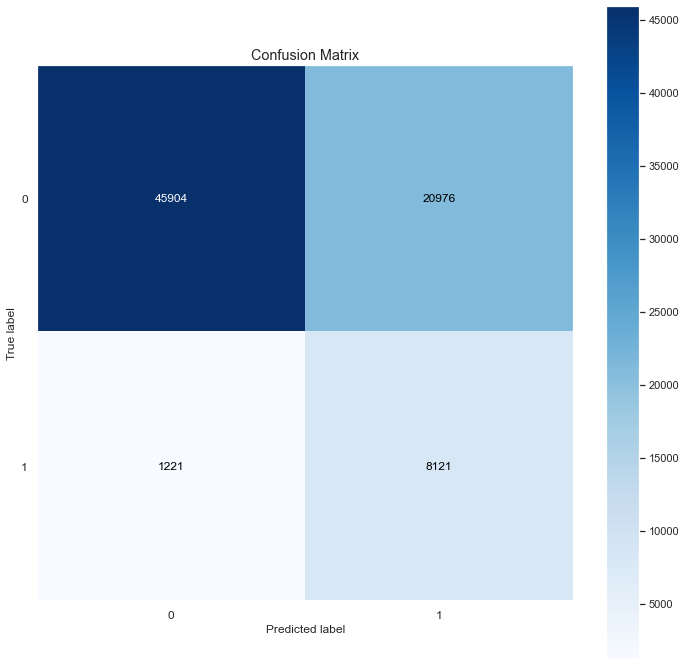

In [103]:
# Classification Report
print(classification_report(y_test_eval, yhat_lgbm_eval))

# Confusion matrix
plot_confusion_matrix(y_test_eval, yhat_lgbm_eval, normalize=False, figsize=(12, 12));

### 12.4.2 Save Model

In [ ]:
 #jb.dump(xgb,'../04-Model/model_xgb.pkl.z')

## 11.5 Model Interpretation (shap)

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train_cv)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_cv.iloc[0,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[10000,:], X_train_cv.iloc[10000,:])

In [ ]:
shap.summary_plot(shap_values[:,:], X_train_cv)

## 11.6 Cumulative gain & Lift

### 11.6.1 Cumulative Gain

In [ ]:
plot_cumulative_gain(y_test_eval, yhat_proba_xgb_eval_2);
plt.vlines(0.1574, 0.0, 0.41, colors='r', linestyles='--')
plt.hlines(0.41, 0.0, 0.1574, colors='r', linestyles='--')

plt.vlines(0.3148, 0.0, 0.765, colors='r', linestyles='--')
plt.hlines(0.765, 0.0, 0.3148, colors='r', linestyles='--')

plt.annotate("41.0% gain with 15.75%\n      of the dataset", xy=(0.1574, 0.41), xytext=(0.05, 0.5), fontsize=16, arrowprops={'arrowstyle':'wedge','color':'gray'});
plt.annotate("76.5% gain with 31.5%\n      of the dataset", xy=(0.3148, 0.765), xytext=(0.18, 0.85), fontsize=16, arrowprops={'arrowstyle':'wedge','color':'gray'});

### 11.6.2 Lift

In [ ]:
plot_lift_curve(y_test_eval, yhat_proba_xgb_eval_2);

In [ ]:

# https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html

#https://www.brainshark.com/ideas-blog/2017/october/cross-sell-metrics-b2b-sales
#https://www.analyticsvidhya.com/blog/2015/08/learn-cross-selling-upselling/
# https://addepto.com/up-selling-cross-selling-5-reasons-use-machine-learning/